# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [3]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [4]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [5]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [6]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [7]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [8]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [9]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [10]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [11]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [12]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [13]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [14]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [15]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [16]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322

[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game_id 322590061.
[97/5670] Updating 5FR Margin for game_id 322590068...
[97/5670] Updated 5FR Margin for game_id 322590068.
[98/5670] Updating 5FR Margin for game_id 322590077...
[98/5670] Updated 5FR Margin for game_id 322590077.
[99/5670] Updating 5FR Margin for game_id 322590084...
[99/5670] Updated 5FR Margin for game_id 322590084.
[100/5670] Updating 5FR Margin for game_id 322590096...
[100/5670] Updated 5FR Margin for ga

[172/5670] Updated 5FR Margin for game_id 322662439.
[173/5670] Updating 5FR Margin for game_id 322662459...
[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 5FR Margin for game_id 322662483.
[175/5670] Updating 5FR Margin for game_id 322662579...
[175/5670] Updated 5FR Margin for game_id 322662579.
[176/5670] Updating 5FR Margin for game_id 322662628...
[176/5670] Updated 5FR Margin for game_id 322662628.
[177/5670] Updating 5FR Margin for game_id 322662633...
[177/5670] Updated 5FR Margin for game_id 322662633.
[178/5670] Updating 5FR Margin for game_id 322662649...
[178/5670] Updated 5FR Margin for game_id 322662649.
[179/5670] Updating 5FR Margin for game_id 322662711...
[179/5670] Updated 5FR Margin for game_id 322662711.
[180/5670] Updating 5FR Margin for game_id 322710264...
[180/5670] Updated 5FR Margin for game_id 322710264.
[181/5670] Updating 5FR Margin for game_id 322720252...
[181/5670] Updated 

[251/5670] Updated 5FR Margin for game_id 322800204.
[252/5670] Updating 5FR Margin for game_id 322800213...
[252/5670] Updated 5FR Margin for game_id 322800213.
[253/5670] Updating 5FR Margin for game_id 322800218...
[253/5670] Updated 5FR Margin for game_id 322800218.
[254/5670] Updating 5FR Margin for game_id 322800228...
[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 5FR Margin for game_id 322800248.
[257/5670] Updating 5FR Margin for game_id 322800251...
[257/5670] Updated 5FR Margin for game_id 322800251.
[258/5670] Updating 5FR Margin for game_id 322800275...
[258/5670] Updated 5FR Margin for game_id 322800275.
[259/5670] Updating 5FR Margin for game_id 322800276...
[259/5670] Updated 5FR Margin for game_id 322800276.
[260/5670] Updating 5FR Margin for game_id 322800309...
[260/5670] Updated 

[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 5FR Margin for game_id 322930183.
[335/5670] Updating 5FR Margin for game_id 322940005...
[335/5670] Updated 5FR Margin for game_id 322940005.
[336/5670] Updating 5FR Margin for game_id 322940006...
[336/5670] Updated 5FR Margin for game_id 322940006.
[337/5670] Updating 5FR Margin for game_id 322940012...
[337/5670] Updated 5FR Margin for game_id 322940012.
[338/5670] Updating 5FR Margin for game_id 322940025...
[338/5670] Updated 5FR Margin for game_id 322940025.
[339/5670] Updating 5FR Margin for game_id 322940030...
[339/5670] Updated 5FR Margin for game_id 322940030.
[340/5670] Updating 5FR Margin for game_id 322940057...
[340/5670] Updated 5FR Margin for game_id 322940057.
[341/5670] Updating 5FR Margin for game_id 322940059...
[341/5670] Updated 

[413/5670] Updated 5FR Margin for game_id 323010189.
[414/5670] Updating 5FR Margin for game_id 323010193...
[414/5670] Updated 5FR Margin for game_id 323010193.
[415/5670] Updating 5FR Margin for game_id 323010197...
[415/5670] Updated 5FR Margin for game_id 323010197.
[416/5670] Updating 5FR Margin for game_id 323010201...
[416/5670] Updated 5FR Margin for game_id 323010201.
[417/5670] Updating 5FR Margin for game_id 323010213...
[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 5FR Margin for game_id 323010221.
[419/5670] Updating 5FR Margin for game_id 323010238...
[419/5670] Updated 5FR Margin for game_id 323010238.
[420/5670] Updating 5FR Margin for game_id 323010242...
[420/5670] Updated 5FR Margin for game_id 323010242.
[421/5670] Updating 5FR Margin for game_id 323010248...
[421/5670] Updated 5FR Margin for game_id 323010248.
[422/5670] Updating 5FR Margin for game_id 323010254...
[422/5670] Updated 

[505/5670] Updated 5FR Margin for game_id 323150005.
[506/5670] Updating 5FR Margin for game_id 323150012...
[506/5670] Updated 5FR Margin for game_id 323150012.
[507/5670] Updating 5FR Margin for game_id 323150021...
[507/5670] Updated 5FR Margin for game_id 323150021.
[508/5670] Updating 5FR Margin for game_id 323150024...
[508/5670] Updated 5FR Margin for game_id 323150024.
[509/5670] Updating 5FR Margin for game_id 323150025...
[509/5670] Updated 5FR Margin for game_id 323150025.
[510/5670] Updating 5FR Margin for game_id 323150030...
[510/5670] Updated 5FR Margin for game_id 323150030.
[511/5670] Updating 5FR Margin for game_id 323150036...
[511/5670] Updated 5FR Margin for game_id 323150036.
[512/5670] Updating 5FR Margin for game_id 323150057...
[512/5670] Updated 5FR Margin for game_id 323150057.
[513/5670] Updating 5FR Margin for game_id 323150062...
[513/5670] Updated 5FR Margin for game_id 323150062.
[514/5670] Updating 5FR Margin for game_id 323150084...
[514/5670] Updated 

[581/5670] Updated 5FR Margin for game_id 323220228.
[582/5670] Updating 5FR Margin for game_id 323220238...
[582/5670] Updated 5FR Margin for game_id 323220238.
[583/5670] Updating 5FR Margin for game_id 323220239...
[583/5670] Updated 5FR Margin for game_id 323220239.
[584/5670] Updating 5FR Margin for game_id 323220242...
[584/5670] Updated 5FR Margin for game_id 323220242.
[585/5670] Updating 5FR Margin for game_id 323220254...
[585/5670] Updated 5FR Margin for game_id 323220254.
[586/5670] Updating 5FR Margin for game_id 323220275...
[586/5670] Updated 5FR Margin for game_id 323220275.
[587/5670] Updating 5FR Margin for game_id 323220276...
[587/5670] Updated 5FR Margin for game_id 323220276.
[588/5670] Updating 5FR Margin for game_id 323220277...
[588/5670] Updated 5FR Margin for game_id 323220277.
[589/5670] Updating 5FR Margin for game_id 323220309...
[589/5670] Updated 5FR Margin for game_id 323220309.
[590/5670] Updating 5FR Margin for game_id 323220344...
[590/5670] Updated 

[664/5670] Updated 5FR Margin for game_id 323352309.
[665/5670] Updating 5FR Margin for game_id 323360041...
[665/5670] Updated 5FR Margin for game_id 323360041.
[666/5670] Updating 5FR Margin for game_id 323360058...
[666/5670] Updated 5FR Margin for game_id 323360058.
[667/5670] Updating 5FR Margin for game_id 323360059...
[667/5670] Updated 5FR Margin for game_id 323360059.
[668/5670] Updating 5FR Margin for game_id 323360061...
[668/5670] Updated 5FR Margin for game_id 323360061.
[669/5670] Updating 5FR Margin for game_id 323360062...
[669/5670] Updated 5FR Margin for game_id 323360062.
[670/5670] Updating 5FR Margin for game_id 323360202...
[670/5670] Updated 5FR Margin for game_id 323360202.
[671/5670] Updating 5FR Margin for game_id 323360239...
[671/5670] Updated 5FR Margin for game_id 323360239.
[672/5670] Updating 5FR Margin for game_id 323360275...
[672/5670] Updated 5FR Margin for game_id 323360275.
[673/5670] Updating 5FR Margin for game_id 323360277...
[673/5670] Updated 

[749/5670] Updated 5FR Margin for game_id 332500213.
[750/5670] Updating 5FR Margin for game_id 332500218...
[750/5670] Updated 5FR Margin for game_id 332500218.
[751/5670] Updating 5FR Margin for game_id 332500235...
[751/5670] Updated 5FR Margin for game_id 332500235.
[752/5670] Updating 5FR Margin for game_id 332500239...
[752/5670] Updated 5FR Margin for game_id 332500239.
[753/5670] Updating 5FR Margin for game_id 332500252...
[753/5670] Updated 5FR Margin for game_id 332500252.
[754/5670] Updating 5FR Margin for game_id 332500258...
[754/5670] Updated 5FR Margin for game_id 332500258.
[755/5670] Updating 5FR Margin for game_id 332500356...
[755/5670] Updated 5FR Margin for game_id 332500356.
[756/5670] Updating 5FR Margin for game_id 332502005...
[756/5670] Updated 5FR Margin for game_id 332502005.
[757/5670] Updating 5FR Margin for game_id 332502050...
[757/5670] Updated 5FR Margin for game_id 332502050.
[758/5670] Updating 5FR Margin for game_id 332502306...
[758/5670] Updated 

[833/5670] Updated 5FR Margin for game_id 332640239.
[834/5670] Updating 5FR Margin for game_id 332640242...
[834/5670] Updated 5FR Margin for game_id 332640242.
[835/5670] Updating 5FR Margin for game_id 332640245...
[835/5670] Updated 5FR Margin for game_id 332640245.
[836/5670] Updating 5FR Margin for game_id 332640251...
[836/5670] Updated 5FR Margin for game_id 332640251.
[837/5670] Updating 5FR Margin for game_id 332640252...
[837/5670] Updated 5FR Margin for game_id 332640252.
[838/5670] Updating 5FR Margin for game_id 332640259...
[838/5670] Updated 5FR Margin for game_id 332640259.
[839/5670] Updating 5FR Margin for game_id 332640275...
[839/5670] Updated 5FR Margin for game_id 332640275.
[840/5670] Updating 5FR Margin for game_id 332640333...
[840/5670] Updated 5FR Margin for game_id 332640333.
[841/5670] Updating 5FR Margin for game_id 332640344...
[841/5670] Updated 5FR Margin for game_id 332640344.
[842/5670] Updating 5FR Margin for game_id 332640349...
[842/5670] Updated 

[912/5670] Updated 5FR Margin for game_id 332780058.
[913/5670] Updating 5FR Margin for game_id 332780062...
[913/5670] Updated 5FR Margin for game_id 332780062.
[914/5670] Updating 5FR Margin for game_id 332780077...
[914/5670] Updated 5FR Margin for game_id 332780077.
[915/5670] Updating 5FR Margin for game_id 332780084...
[915/5670] Updated 5FR Margin for game_id 332780084.
[916/5670] Updating 5FR Margin for game_id 332780087...
[916/5670] Updated 5FR Margin for game_id 332780087.
[917/5670] Updating 5FR Margin for game_id 332780103...
[917/5670] Updated 5FR Margin for game_id 332780103.
[918/5670] Updating 5FR Margin for game_id 332780130...
[918/5670] Updated 5FR Margin for game_id 332780130.
[919/5670] Updating 5FR Margin for game_id 332780154...
[919/5670] Updated 5FR Margin for game_id 332780154.
[920/5670] Updating 5FR Margin for game_id 332780158...
[920/5670] Updated 5FR Margin for game_id 332780158.
[921/5670] Updating 5FR Margin for game_id 332780167...
[921/5670] Updated 

[989/5670] Updated 5FR Margin for game_id 332852050.
[990/5670] Updating 5FR Margin for game_id 332852226...
[990/5670] Updated 5FR Margin for game_id 332852226.
[991/5670] Updating 5FR Margin for game_id 332852229...
[991/5670] Updated 5FR Margin for game_id 332852229.
[992/5670] Updating 5FR Margin for game_id 332852247...
[992/5670] Updated 5FR Margin for game_id 332852247.
[993/5670] Updating 5FR Margin for game_id 332852306...
[993/5670] Updated 5FR Margin for game_id 332852306.
[994/5670] Updating 5FR Margin for game_id 332852439...
[994/5670] Updated 5FR Margin for game_id 332852439.
[995/5670] Updating 5FR Margin for game_id 332852459...
[995/5670] Updated 5FR Margin for game_id 332852459.
[996/5670] Updating 5FR Margin for game_id 332852509...
[996/5670] Updated 5FR Margin for game_id 332852509.
[997/5670] Updating 5FR Margin for game_id 332852628...
[997/5670] Updated 5FR Margin for game_id 332852628.
[998/5670] Updating 5FR Margin for game_id 332852636...
[998/5670] Updated 

[1067/5670] Updated 5FR Margin for game_id 332990120.
[1068/5670] Updating 5FR Margin for game_id 332990135...
[1068/5670] Updated 5FR Margin for game_id 332990135.
[1069/5670] Updating 5FR Margin for game_id 332990142...
[1069/5670] Updated 5FR Margin for game_id 332990142.
[1070/5670] Updating 5FR Margin for game_id 332990153...
[1070/5670] Updated 5FR Margin for game_id 332990153.
[1071/5670] Updating 5FR Margin for game_id 332990164...
[1071/5670] Updated 5FR Margin for game_id 332990164.
[1072/5670] Updating 5FR Margin for game_id 332990189...
[1072/5670] Updated 5FR Margin for game_id 332990189.
[1073/5670] Updating 5FR Margin for game_id 332990194...
[1073/5670] Updated 5FR Margin for game_id 332990194.
[1074/5670] Updating 5FR Margin for game_id 332990195...
[1074/5670] Updated 5FR Margin for game_id 332990195.
[1075/5670] Updating 5FR Margin for game_id 332990201...
[1075/5670] Updated 5FR Margin for game_id 332990201.
[1076/5670] Updating 5FR Margin for game_id 332990204...
[

[1144/5670] Updated 5FR Margin for game_id 333062294.
[1145/5670] Updating 5FR Margin for game_id 333062306...
[1145/5670] Updated 5FR Margin for game_id 333062306.
[1146/5670] Updating 5FR Margin for game_id 333062439...
[1146/5670] Updated 5FR Margin for game_id 333062439.
[1147/5670] Updating 5FR Margin for game_id 333062509...
[1147/5670] Updated 5FR Margin for game_id 333062509.
[1148/5670] Updating 5FR Margin for game_id 333062579...
[1148/5670] Updated 5FR Margin for game_id 333062579.
[1149/5670] Updating 5FR Margin for game_id 333062628...
[1149/5670] Updated 5FR Margin for game_id 333062628.
[1150/5670] Updating 5FR Margin for game_id 333062641...
[1150/5670] Updated 5FR Margin for game_id 333062641.
[1151/5670] Updating 5FR Margin for game_id 333062649...
[1151/5670] Updated 5FR Margin for game_id 333062649.
[1152/5670] Updating 5FR Margin for game_id 333090193...
[1152/5670] Updated 5FR Margin for game_id 333090193.
[1153/5670] Updating 5FR Margin for game_id 333092084...
[

[1221/5670] Updated 5FR Margin for game_id 333200103.
[1222/5670] Updating 5FR Margin for game_id 333200113...
[1222/5670] Updated 5FR Margin for game_id 333200113.
[1223/5670] Updating 5FR Margin for game_id 333200145...
[1223/5670] Updated 5FR Margin for game_id 333200145.
[1224/5670] Updating 5FR Margin for game_id 333200150...
[1224/5670] Updated 5FR Margin for game_id 333200150.
[1225/5670] Updating 5FR Margin for game_id 333200151...
[1225/5670] Updated 5FR Margin for game_id 333200151.
[1226/5670] Updating 5FR Margin for game_id 333200158...
[1226/5670] Updated 5FR Margin for game_id 333200158.
[1227/5670] Updating 5FR Margin for game_id 333200164...
[1227/5670] Updated 5FR Margin for game_id 333200164.
[1228/5670] Updating 5FR Margin for game_id 333200167...
[1228/5670] Updated 5FR Margin for game_id 333200167.
[1229/5670] Updating 5FR Margin for game_id 333200201...
[1229/5670] Updated 5FR Margin for game_id 333200201.
[1230/5670] Updating 5FR Margin for game_id 333200213...
[

[1298/5670] Updated 5FR Margin for game_id 333272294.
[1299/5670] Updating 5FR Margin for game_id 333272306...
[1299/5670] Updated 5FR Margin for game_id 333272306.
[1300/5670] Updating 5FR Margin for game_id 333272348...
[1300/5670] Updated 5FR Margin for game_id 333272348.
[1301/5670] Updating 5FR Margin for game_id 333272390...
[1301/5670] Updated 5FR Margin for game_id 333272390.
[1302/5670] Updating 5FR Margin for game_id 333272509...
[1302/5670] Updated 5FR Margin for game_id 333272509.
[1303/5670] Updating 5FR Margin for game_id 333272572...
[1303/5670] Updated 5FR Margin for game_id 333272572.
[1304/5670] Updating 5FR Margin for game_id 333272579...
[1304/5670] Updated 5FR Margin for game_id 333272579.
[1305/5670] Updating 5FR Margin for game_id 333272633...
[1305/5670] Updated 5FR Margin for game_id 333272633.
[1306/5670] Updating 5FR Margin for game_id 333272655...
[1306/5670] Updated 5FR Margin for game_id 333272655.
[1307/5670] Updating 5FR Margin for game_id 333272751...
[

[1376/5670] Updated 5FR Margin for game_id 333410239.
[1377/5670] Updating 5FR Margin for game_id 333410242...
[1377/5670] Updated 5FR Margin for game_id 333410242.
[1378/5670] Updating 5FR Margin for game_id 333410278...
[1378/5670] Updated 5FR Margin for game_id 333410278.
[1379/5670] Updating 5FR Margin for game_id 333412567...
[1379/5670] Updated 5FR Margin for game_id 333412567.
[1380/5670] Updating 5FR Margin for game_id 333482426...
[1380/5670] Updated 5FR Margin for game_id 333482426.
[1381/5670] Updating 5FR Margin for game_id 400547640...
[1381/5670] Updated 5FR Margin for game_id 400547640.
[1382/5670] Updating 5FR Margin for game_id 400547641...
[1382/5670] Updated 5FR Margin for game_id 400547641.
[1383/5670] Updating 5FR Margin for game_id 400547642...
[1383/5670] Updated 5FR Margin for game_id 400547642.
[1384/5670] Updating 5FR Margin for game_id 400547644...
[1384/5670] Updated 5FR Margin for game_id 400547644.
[1385/5670] Updating 5FR Margin for game_id 400547647...
[

[1454/5670] Updated 5FR Margin for game_id 400547724.
[1455/5670] Updating 5FR Margin for game_id 400547725...
[1455/5670] Updated 5FR Margin for game_id 400547725.
[1456/5670] Updating 5FR Margin for game_id 400547726...
[1456/5670] Updated 5FR Margin for game_id 400547726.
[1457/5670] Updating 5FR Margin for game_id 400547727...
[1457/5670] Updated 5FR Margin for game_id 400547727.
[1458/5670] Updating 5FR Margin for game_id 400547728...
[1458/5670] Updated 5FR Margin for game_id 400547728.
[1459/5670] Updating 5FR Margin for game_id 400547729...
[1459/5670] Updated 5FR Margin for game_id 400547729.
[1460/5670] Updating 5FR Margin for game_id 400547730...
[1460/5670] Updated 5FR Margin for game_id 400547730.
[1461/5670] Updating 5FR Margin for game_id 400547732...
[1461/5670] Updated 5FR Margin for game_id 400547732.
[1462/5670] Updating 5FR Margin for game_id 400547733...
[1462/5670] Updated 5FR Margin for game_id 400547733.
[1463/5670] Updating 5FR Margin for game_id 400547734...
[

[1536/5670] Updated 5FR Margin for game_id 400547817.
[1537/5670] Updating 5FR Margin for game_id 400547818...
[1537/5670] Updated 5FR Margin for game_id 400547818.
[1538/5670] Updating 5FR Margin for game_id 400547819...
[1538/5670] Updated 5FR Margin for game_id 400547819.
[1539/5670] Updating 5FR Margin for game_id 400547820...
[1539/5670] Updated 5FR Margin for game_id 400547820.
[1540/5670] Updating 5FR Margin for game_id 400547822...
[1540/5670] Updated 5FR Margin for game_id 400547822.
[1541/5670] Updating 5FR Margin for game_id 400547823...
[1541/5670] Updated 5FR Margin for game_id 400547823.
[1542/5670] Updating 5FR Margin for game_id 400547824...
[1542/5670] Updated 5FR Margin for game_id 400547824.
[1543/5670] Updating 5FR Margin for game_id 400547826...
[1543/5670] Updated 5FR Margin for game_id 400547826.
[1544/5670] Updating 5FR Margin for game_id 400547827...
[1544/5670] Updated 5FR Margin for game_id 400547827.
[1545/5670] Updating 5FR Margin for game_id 400547828...
[

[1613/5670] Updated 5FR Margin for game_id 400547907.
[1614/5670] Updating 5FR Margin for game_id 400547908...
[1614/5670] Updated 5FR Margin for game_id 400547908.
[1615/5670] Updating 5FR Margin for game_id 400547909...
[1615/5670] Updated 5FR Margin for game_id 400547909.
[1616/5670] Updating 5FR Margin for game_id 400547910...
[1616/5670] Updated 5FR Margin for game_id 400547910.
[1617/5670] Updating 5FR Margin for game_id 400547911...
[1617/5670] Updated 5FR Margin for game_id 400547911.
[1618/5670] Updating 5FR Margin for game_id 400547912...
[1618/5670] Updated 5FR Margin for game_id 400547912.
[1619/5670] Updating 5FR Margin for game_id 400547913...
[1619/5670] Updated 5FR Margin for game_id 400547913.
[1620/5670] Updating 5FR Margin for game_id 400547914...
[1620/5670] Updated 5FR Margin for game_id 400547914.
[1621/5670] Updating 5FR Margin for game_id 400547915...
[1621/5670] Updated 5FR Margin for game_id 400547915.
[1622/5670] Updating 5FR Margin for game_id 400547917...
[

[1688/5670] Updated 5FR Margin for game_id 400547990.
[1689/5670] Updating 5FR Margin for game_id 400547992...
[1689/5670] Updated 5FR Margin for game_id 400547992.
[1690/5670] Updating 5FR Margin for game_id 400547993...
[1690/5670] Updated 5FR Margin for game_id 400547993.
[1691/5670] Updating 5FR Margin for game_id 400547995...
[1691/5670] Updated 5FR Margin for game_id 400547995.
[1692/5670] Updating 5FR Margin for game_id 400547996...
[1692/5670] Updated 5FR Margin for game_id 400547996.
[1693/5670] Updating 5FR Margin for game_id 400547997...
[1693/5670] Updated 5FR Margin for game_id 400547997.
[1694/5670] Updating 5FR Margin for game_id 400547998...
[1694/5670] Updated 5FR Margin for game_id 400547998.
[1695/5670] Updating 5FR Margin for game_id 400547999...
[1695/5670] Updated 5FR Margin for game_id 400547999.
[1696/5670] Updating 5FR Margin for game_id 400548000...
[1696/5670] Updated 5FR Margin for game_id 400548000.
[1697/5670] Updating 5FR Margin for game_id 400548002...
[

[1767/5670] Updated 5FR Margin for game_id 400548086.
[1768/5670] Updating 5FR Margin for game_id 400548087...
[1768/5670] Updated 5FR Margin for game_id 400548087.
[1769/5670] Updating 5FR Margin for game_id 400548088...
[1769/5670] Updated 5FR Margin for game_id 400548088.
[1770/5670] Updating 5FR Margin for game_id 400548089...
[1770/5670] Updated 5FR Margin for game_id 400548089.
[1771/5670] Updating 5FR Margin for game_id 400548097...
[1771/5670] Updated 5FR Margin for game_id 400548097.
[1772/5670] Updating 5FR Margin for game_id 400548098...
[1772/5670] Updated 5FR Margin for game_id 400548098.
[1773/5670] Updating 5FR Margin for game_id 400548099...
[1773/5670] Updated 5FR Margin for game_id 400548099.
[1774/5670] Updating 5FR Margin for game_id 400548101...
[1774/5670] Updated 5FR Margin for game_id 400548101.
[1775/5670] Updating 5FR Margin for game_id 400548102...
[1775/5670] Updated 5FR Margin for game_id 400548102.
[1776/5670] Updating 5FR Margin for game_id 400548103...
[

[1846/5670] Updated 5FR Margin for game_id 400548193.
[1847/5670] Updating 5FR Margin for game_id 400548194...
[1847/5670] Updated 5FR Margin for game_id 400548194.
[1848/5670] Updating 5FR Margin for game_id 400548196...
[1848/5670] Updated 5FR Margin for game_id 400548196.
[1849/5670] Updating 5FR Margin for game_id 400548197...
[1849/5670] Updated 5FR Margin for game_id 400548197.
[1850/5670] Updating 5FR Margin for game_id 400548198...
[1850/5670] Updated 5FR Margin for game_id 400548198.
[1851/5670] Updating 5FR Margin for game_id 400548199...
[1851/5670] Updated 5FR Margin for game_id 400548199.
[1852/5670] Updating 5FR Margin for game_id 400548200...
[1852/5670] Updated 5FR Margin for game_id 400548200.
[1853/5670] Updating 5FR Margin for game_id 400548201...
[1853/5670] Updated 5FR Margin for game_id 400548201.
[1854/5670] Updating 5FR Margin for game_id 400548202...
[1854/5670] Updated 5FR Margin for game_id 400548202.
[1855/5670] Updating 5FR Margin for game_id 400548203...
[

[1921/5670] Updated 5FR Margin for game_id 400548281.
[1922/5670] Updating 5FR Margin for game_id 400548282...
[1922/5670] Updated 5FR Margin for game_id 400548282.
[1923/5670] Updating 5FR Margin for game_id 400548283...
[1923/5670] Updated 5FR Margin for game_id 400548283.
[1924/5670] Updating 5FR Margin for game_id 400548284...
[1924/5670] Updated 5FR Margin for game_id 400548284.
[1925/5670] Updating 5FR Margin for game_id 400548285...
[1925/5670] Updated 5FR Margin for game_id 400548285.
[1926/5670] Updating 5FR Margin for game_id 400548286...
[1926/5670] Updated 5FR Margin for game_id 400548286.
[1927/5670] Updating 5FR Margin for game_id 400548287...
[1927/5670] Updated 5FR Margin for game_id 400548287.
[1928/5670] Updating 5FR Margin for game_id 400548288...
[1928/5670] Updated 5FR Margin for game_id 400548288.
[1929/5670] Updating 5FR Margin for game_id 400548289...
[1929/5670] Updated 5FR Margin for game_id 400548289.
[1930/5670] Updating 5FR Margin for game_id 400548290...
[

[2003/5670] Updated 5FR Margin for game_id 400548370.
[2004/5670] Updating 5FR Margin for game_id 400548373...
[2004/5670] Updated 5FR Margin for game_id 400548373.
[2005/5670] Updating 5FR Margin for game_id 400548374...
[2005/5670] Updated 5FR Margin for game_id 400548374.
[2006/5670] Updating 5FR Margin for game_id 400548375...
[2006/5670] Updated 5FR Margin for game_id 400548375.
[2007/5670] Updating 5FR Margin for game_id 400548376...
[2007/5670] Updated 5FR Margin for game_id 400548376.
[2008/5670] Updating 5FR Margin for game_id 400548377...
[2008/5670] Updated 5FR Margin for game_id 400548377.
[2009/5670] Updating 5FR Margin for game_id 400548378...
[2009/5670] Updated 5FR Margin for game_id 400548378.
[2010/5670] Updating 5FR Margin for game_id 400548379...
[2010/5670] Updated 5FR Margin for game_id 400548379.
[2011/5670] Updating 5FR Margin for game_id 400548380...
[2011/5670] Updated 5FR Margin for game_id 400548380.
[2012/5670] Updating 5FR Margin for game_id 400548381...
[

[2079/5670] Updated 5FR Margin for game_id 400603839.
[2080/5670] Updating 5FR Margin for game_id 400603840...
[2080/5670] Updated 5FR Margin for game_id 400603840.
[2081/5670] Updating 5FR Margin for game_id 400603841...
[2081/5670] Updated 5FR Margin for game_id 400603841.
[2082/5670] Updating 5FR Margin for game_id 400603842...
[2082/5670] Updated 5FR Margin for game_id 400603842.
[2083/5670] Updating 5FR Margin for game_id 400603843...
[2083/5670] Updated 5FR Margin for game_id 400603843.
[2084/5670] Updating 5FR Margin for game_id 400603844...
[2084/5670] Updated 5FR Margin for game_id 400603844.
[2085/5670] Updating 5FR Margin for game_id 400603846...
[2085/5670] Updated 5FR Margin for game_id 400603846.
[2086/5670] Updating 5FR Margin for game_id 400603847...
[2086/5670] Updated 5FR Margin for game_id 400603847.
[2087/5670] Updating 5FR Margin for game_id 400603848...
[2087/5670] Updated 5FR Margin for game_id 400603848.
[2088/5670] Updating 5FR Margin for game_id 400603849...
[

[2159/5670] Updated 5FR Margin for game_id 400603928.
[2160/5670] Updating 5FR Margin for game_id 400603930...
[2160/5670] Updated 5FR Margin for game_id 400603930.
[2161/5670] Updating 5FR Margin for game_id 400603931...
[2161/5670] Updated 5FR Margin for game_id 400603931.
[2162/5670] Updating 5FR Margin for game_id 400603932...
[2162/5670] Updated 5FR Margin for game_id 400603932.
[2163/5670] Updating 5FR Margin for game_id 400603933...
[2163/5670] Updated 5FR Margin for game_id 400603933.
[2164/5670] Updating 5FR Margin for game_id 400603934...
[2164/5670] Updated 5FR Margin for game_id 400603934.
[2165/5670] Updating 5FR Margin for game_id 400603935...
[2165/5670] Updated 5FR Margin for game_id 400603935.
[2166/5670] Updating 5FR Margin for game_id 400603937...
[2166/5670] Updated 5FR Margin for game_id 400603937.
[2167/5670] Updating 5FR Margin for game_id 400608167...
[2167/5670] Updated 5FR Margin for game_id 400608167.
[2168/5670] Updating 5FR Margin for game_id 400609055...
[

[2235/5670] Updated 5FR Margin for game_id 400756966.
[2236/5670] Updating 5FR Margin for game_id 400756967...
[2236/5670] Updated 5FR Margin for game_id 400756967.
[2237/5670] Updating 5FR Margin for game_id 400756968...
[2237/5670] Updated 5FR Margin for game_id 400756968.
[2238/5670] Updating 5FR Margin for game_id 400756969...
[2238/5670] Updated 5FR Margin for game_id 400756969.
[2239/5670] Updating 5FR Margin for game_id 400756970...
[2239/5670] Updated 5FR Margin for game_id 400756970.
[2240/5670] Updating 5FR Margin for game_id 400756971...
[2240/5670] Updated 5FR Margin for game_id 400756971.
[2241/5670] Updating 5FR Margin for game_id 400756972...
[2241/5670] Updated 5FR Margin for game_id 400756972.
[2242/5670] Updating 5FR Margin for game_id 400756973...
[2242/5670] Updated 5FR Margin for game_id 400756973.
[2243/5670] Updating 5FR Margin for game_id 400756974...
[2243/5670] Updated 5FR Margin for game_id 400756974.
[2244/5670] Updating 5FR Margin for game_id 400756975...
[

[2310/5670] Updated 5FR Margin for game_id 400757063.
[2311/5670] Updating 5FR Margin for game_id 400757064...
[2311/5670] Updated 5FR Margin for game_id 400757064.
[2312/5670] Updating 5FR Margin for game_id 400757065...
[2312/5670] Updated 5FR Margin for game_id 400757065.
[2313/5670] Updating 5FR Margin for game_id 400757066...
[2313/5670] Updated 5FR Margin for game_id 400757066.
[2314/5670] Updating 5FR Margin for game_id 400757067...
[2314/5670] Updated 5FR Margin for game_id 400757067.
[2315/5670] Updating 5FR Margin for game_id 400757068...
[2315/5670] Updated 5FR Margin for game_id 400757068.
[2316/5670] Updating 5FR Margin for game_id 400757069...
[2316/5670] Updated 5FR Margin for game_id 400757069.
[2317/5670] Updating 5FR Margin for game_id 400757070...
[2317/5670] Updated 5FR Margin for game_id 400757070.
[2318/5670] Updating 5FR Margin for game_id 400757071...
[2318/5670] Updated 5FR Margin for game_id 400757071.
[2319/5670] Updating 5FR Margin for game_id 400757072...
[

[2392/5670] Updated 5FR Margin for game_id 400763452.
[2393/5670] Updating 5FR Margin for game_id 400763453...
[2393/5670] Updated 5FR Margin for game_id 400763453.
[2394/5670] Updating 5FR Margin for game_id 400763454...
[2394/5670] Updated 5FR Margin for game_id 400763454.
[2395/5670] Updating 5FR Margin for game_id 400763455...
[2395/5670] Updated 5FR Margin for game_id 400763455.
[2396/5670] Updating 5FR Margin for game_id 400763456...
[2396/5670] Updated 5FR Margin for game_id 400763456.
[2397/5670] Updating 5FR Margin for game_id 400763457...
[2397/5670] Updated 5FR Margin for game_id 400763457.
[2398/5670] Updating 5FR Margin for game_id 400763458...
[2398/5670] Updated 5FR Margin for game_id 400763458.
[2399/5670] Updating 5FR Margin for game_id 400763459...
[2399/5670] Updated 5FR Margin for game_id 400763459.
[2400/5670] Updating 5FR Margin for game_id 400763460...
[2400/5670] Updated 5FR Margin for game_id 400763460.
[2401/5670] Updating 5FR Margin for game_id 400763461...
[

[2469/5670] Updated 5FR Margin for game_id 400763557.
[2470/5670] Updating 5FR Margin for game_id 400763558...
[2470/5670] Updated 5FR Margin for game_id 400763558.
[2471/5670] Updating 5FR Margin for game_id 400763559...
[2471/5670] Updated 5FR Margin for game_id 400763559.
[2472/5670] Updating 5FR Margin for game_id 400763560...
[2472/5670] Updated 5FR Margin for game_id 400763560.
[2473/5670] Updating 5FR Margin for game_id 400763561...
[2473/5670] Updated 5FR Margin for game_id 400763561.
[2474/5670] Updating 5FR Margin for game_id 400763562...
[2474/5670] Updated 5FR Margin for game_id 400763562.
[2475/5670] Updating 5FR Margin for game_id 400763563...
[2475/5670] Updated 5FR Margin for game_id 400763563.
[2476/5670] Updating 5FR Margin for game_id 400763564...
[2476/5670] Updated 5FR Margin for game_id 400763564.
[2477/5670] Updating 5FR Margin for game_id 400763565...
[2477/5670] Updated 5FR Margin for game_id 400763565.
[2478/5670] Updating 5FR Margin for game_id 400763566...
[

[2552/5670] Updated 5FR Margin for game_id 400763652.
[2553/5670] Updating 5FR Margin for game_id 400763653...
[2553/5670] Updated 5FR Margin for game_id 400763653.
[2554/5670] Updating 5FR Margin for game_id 400763655...
[2554/5670] Updated 5FR Margin for game_id 400763655.
[2555/5670] Updating 5FR Margin for game_id 400763656...
[2555/5670] Updated 5FR Margin for game_id 400763656.
[2556/5670] Updating 5FR Margin for game_id 400763657...
[2556/5670] Updated 5FR Margin for game_id 400763657.
[2557/5670] Updating 5FR Margin for game_id 400763658...
[2557/5670] Updated 5FR Margin for game_id 400763658.
[2558/5670] Updating 5FR Margin for game_id 400763659...
[2558/5670] Updated 5FR Margin for game_id 400763659.
[2559/5670] Updating 5FR Margin for game_id 400763660...
[2559/5670] Updated 5FR Margin for game_id 400763660.
[2560/5670] Updating 5FR Margin for game_id 400763661...
[2560/5670] Updated 5FR Margin for game_id 400763661.
[2561/5670] Updating 5FR Margin for game_id 400763662...
[

[2629/5670] Updated 5FR Margin for game_id 400787241.
[2630/5670] Updating 5FR Margin for game_id 400787243...
[2630/5670] Updated 5FR Margin for game_id 400787243.
[2631/5670] Updating 5FR Margin for game_id 400787244...
[2631/5670] Updated 5FR Margin for game_id 400787244.
[2632/5670] Updating 5FR Margin for game_id 400787245...
[2632/5670] Updated 5FR Margin for game_id 400787245.
[2633/5670] Updating 5FR Margin for game_id 400787246...
[2633/5670] Updated 5FR Margin for game_id 400787246.
[2634/5670] Updating 5FR Margin for game_id 400787248...
[2634/5670] Updated 5FR Margin for game_id 400787248.
[2635/5670] Updating 5FR Margin for game_id 400787249...
[2635/5670] Updated 5FR Margin for game_id 400787249.
[2636/5670] Updating 5FR Margin for game_id 400787250...
[2636/5670] Updated 5FR Margin for game_id 400787250.
[2637/5670] Updating 5FR Margin for game_id 400787251...
[2637/5670] Updated 5FR Margin for game_id 400787251.
[2638/5670] Updating 5FR Margin for game_id 400787252...
[

[2712/5670] Updated 5FR Margin for game_id 400787347.
[2713/5670] Updating 5FR Margin for game_id 400787348...
[2713/5670] Updated 5FR Margin for game_id 400787348.
[2714/5670] Updating 5FR Margin for game_id 400787349...
[2714/5670] Updated 5FR Margin for game_id 400787349.
[2715/5670] Updating 5FR Margin for game_id 400787350...
[2715/5670] Updated 5FR Margin for game_id 400787350.
[2716/5670] Updating 5FR Margin for game_id 400787351...
[2716/5670] Updated 5FR Margin for game_id 400787351.
[2717/5670] Updating 5FR Margin for game_id 400787352...
[2717/5670] Updated 5FR Margin for game_id 400787352.
[2718/5670] Updating 5FR Margin for game_id 400787353...
[2718/5670] Updated 5FR Margin for game_id 400787353.
[2719/5670] Updating 5FR Margin for game_id 400787354...
[2719/5670] Updated 5FR Margin for game_id 400787354.
[2720/5670] Updating 5FR Margin for game_id 400787355...
[2720/5670] Updated 5FR Margin for game_id 400787355.
[2721/5670] Updating 5FR Margin for game_id 400787356...
[

[2787/5670] Updated 5FR Margin for game_id 400868877.
[2788/5670] Updating 5FR Margin for game_id 400868878...
[2788/5670] Updated 5FR Margin for game_id 400868878.
[2789/5670] Updating 5FR Margin for game_id 400868879...
[2789/5670] Updated 5FR Margin for game_id 400868879.
[2790/5670] Updating 5FR Margin for game_id 400868880...
[2790/5670] Updated 5FR Margin for game_id 400868880.
[2791/5670] Updating 5FR Margin for game_id 400868881...
[2791/5670] Updated 5FR Margin for game_id 400868881.
[2792/5670] Updating 5FR Margin for game_id 400868882...
[2792/5670] Updated 5FR Margin for game_id 400868882.
[2793/5670] Updating 5FR Margin for game_id 400868883...
[2793/5670] Updated 5FR Margin for game_id 400868883.
[2794/5670] Updating 5FR Margin for game_id 400868884...
[2794/5670] Updated 5FR Margin for game_id 400868884.
[2795/5670] Updating 5FR Margin for game_id 400868885...
[2795/5670] Updated 5FR Margin for game_id 400868885.
[2796/5670] Updating 5FR Margin for game_id 400868886...
[

[2870/5670] Updated 5FR Margin for game_id 400869004.
[2871/5670] Updating 5FR Margin for game_id 400869005...
[2871/5670] Updated 5FR Margin for game_id 400869005.
[2872/5670] Updating 5FR Margin for game_id 400869007...
[2872/5670] Updated 5FR Margin for game_id 400869007.
[2873/5670] Updating 5FR Margin for game_id 400869008...
[2873/5670] Updated 5FR Margin for game_id 400869008.
[2874/5670] Updating 5FR Margin for game_id 400869009...
[2874/5670] Updated 5FR Margin for game_id 400869009.
[2875/5670] Updating 5FR Margin for game_id 400869010...
[2875/5670] Updated 5FR Margin for game_id 400869010.
[2876/5670] Updating 5FR Margin for game_id 400869012...
[2876/5670] Updated 5FR Margin for game_id 400869012.
[2877/5670] Updating 5FR Margin for game_id 400869013...
[2877/5670] Updated 5FR Margin for game_id 400869013.
[2878/5670] Updating 5FR Margin for game_id 400869014...
[2878/5670] Updated 5FR Margin for game_id 400869014.
[2879/5670] Updating 5FR Margin for game_id 400869015...
[

[2951/5670] Updated 5FR Margin for game_id 400869121.
[2952/5670] Updating 5FR Margin for game_id 400869122...
[2952/5670] Updated 5FR Margin for game_id 400869122.
[2953/5670] Updating 5FR Margin for game_id 400869123...
[2953/5670] Updated 5FR Margin for game_id 400869123.
[2954/5670] Updating 5FR Margin for game_id 400869124...
[2954/5670] Updated 5FR Margin for game_id 400869124.
[2955/5670] Updating 5FR Margin for game_id 400869125...
[2955/5670] Updated 5FR Margin for game_id 400869125.
[2956/5670] Updating 5FR Margin for game_id 400869126...
[2956/5670] Updated 5FR Margin for game_id 400869126.
[2957/5670] Updating 5FR Margin for game_id 400869127...
[2957/5670] Updated 5FR Margin for game_id 400869127.
[2958/5670] Updating 5FR Margin for game_id 400869128...
[2958/5670] Updated 5FR Margin for game_id 400869128.
[2959/5670] Updating 5FR Margin for game_id 400869129...
[2959/5670] Updated 5FR Margin for game_id 400869129.
[2960/5670] Updating 5FR Margin for game_id 400869130...
[

[3035/5670] Updated 5FR Margin for game_id 400869218.
[3036/5670] Updating 5FR Margin for game_id 400869219...
[3036/5670] Updated 5FR Margin for game_id 400869219.
[3037/5670] Updating 5FR Margin for game_id 400869220...
[3037/5670] Updated 5FR Margin for game_id 400869220.
[3038/5670] Updating 5FR Margin for game_id 400869221...
[3038/5670] Updated 5FR Margin for game_id 400869221.
[3039/5670] Updating 5FR Margin for game_id 400869222...
[3039/5670] Updated 5FR Margin for game_id 400869222.
[3040/5670] Updating 5FR Margin for game_id 400869223...
[3040/5670] Updated 5FR Margin for game_id 400869223.
[3041/5670] Updating 5FR Margin for game_id 400869224...
[3041/5670] Updated 5FR Margin for game_id 400869224.
[3042/5670] Updating 5FR Margin for game_id 400869225...
[3042/5670] Updated 5FR Margin for game_id 400869225.
[3043/5670] Updating 5FR Margin for game_id 400869226...
[3043/5670] Updated 5FR Margin for game_id 400869226.
[3044/5670] Updating 5FR Margin for game_id 400869227...
[

[3114/5670] Updated 5FR Margin for game_id 400869313.
[3115/5670] Updating 5FR Margin for game_id 400869314...
[3115/5670] Updated 5FR Margin for game_id 400869314.
[3116/5670] Updating 5FR Margin for game_id 400869315...
[3116/5670] Updated 5FR Margin for game_id 400869315.
[3117/5670] Updating 5FR Margin for game_id 400869316...
[3117/5670] Updated 5FR Margin for game_id 400869316.
[3118/5670] Updating 5FR Margin for game_id 400869317...
[3118/5670] Updated 5FR Margin for game_id 400869317.
[3119/5670] Updating 5FR Margin for game_id 400869318...
[3119/5670] Updated 5FR Margin for game_id 400869318.
[3120/5670] Updating 5FR Margin for game_id 400869319...
[3120/5670] Updated 5FR Margin for game_id 400869319.
[3121/5670] Updating 5FR Margin for game_id 400869320...
[3121/5670] Updated 5FR Margin for game_id 400869320.
[3122/5670] Updating 5FR Margin for game_id 400869321...
[3122/5670] Updated 5FR Margin for game_id 400869321.
[3123/5670] Updating 5FR Margin for game_id 400869322...
[

[3193/5670] Updated 5FR Margin for game_id 400869407.
[3194/5670] Updating 5FR Margin for game_id 400869408...
[3194/5670] Updated 5FR Margin for game_id 400869408.
[3195/5670] Updating 5FR Margin for game_id 400869409...
[3195/5670] Updated 5FR Margin for game_id 400869409.
[3196/5670] Updating 5FR Margin for game_id 400869410...
[3196/5670] Updated 5FR Margin for game_id 400869410.
[3197/5670] Updating 5FR Margin for game_id 400869411...
[3197/5670] Updated 5FR Margin for game_id 400869411.
[3198/5670] Updating 5FR Margin for game_id 400869412...
[3198/5670] Updated 5FR Margin for game_id 400869412.
[3199/5670] Updating 5FR Margin for game_id 400869413...
[3199/5670] Updated 5FR Margin for game_id 400869413.
[3200/5670] Updating 5FR Margin for game_id 400869414...
[3200/5670] Updated 5FR Margin for game_id 400869414.
[3201/5670] Updating 5FR Margin for game_id 400869415...
[3201/5670] Updated 5FR Margin for game_id 400869415.
[3202/5670] Updating 5FR Margin for game_id 400869416...
[

[3270/5670] Updated 5FR Margin for game_id 400869497.
[3271/5670] Updating 5FR Margin for game_id 400869498...
[3271/5670] Updated 5FR Margin for game_id 400869498.
[3272/5670] Updating 5FR Margin for game_id 400869499...
[3272/5670] Updated 5FR Margin for game_id 400869499.
[3273/5670] Updating 5FR Margin for game_id 400869500...
[3273/5670] Updated 5FR Margin for game_id 400869500.
[3274/5670] Updating 5FR Margin for game_id 400869501...
[3274/5670] Updated 5FR Margin for game_id 400869501.
[3275/5670] Updating 5FR Margin for game_id 400869507...
[3275/5670] Updated 5FR Margin for game_id 400869507.
[3276/5670] Updating 5FR Margin for game_id 400869510...
[3276/5670] Updated 5FR Margin for game_id 400869510.
[3277/5670] Updating 5FR Margin for game_id 400869511...
[3277/5670] Updated 5FR Margin for game_id 400869511.
[3278/5670] Updating 5FR Margin for game_id 400869512...
[3278/5670] Updated 5FR Margin for game_id 400869512.
[3279/5670] Updating 5FR Margin for game_id 400869516...
[

[3347/5670] Updated 5FR Margin for game_id 400869607.
[3348/5670] Updating 5FR Margin for game_id 400869608...
[3348/5670] Updated 5FR Margin for game_id 400869608.
[3349/5670] Updating 5FR Margin for game_id 400869609...
[3349/5670] Updated 5FR Margin for game_id 400869609.
[3350/5670] Updating 5FR Margin for game_id 400869610...
[3350/5670] Updated 5FR Margin for game_id 400869610.
[3351/5670] Updating 5FR Margin for game_id 400869611...
[3351/5670] Updated 5FR Margin for game_id 400869611.
[3352/5670] Updating 5FR Margin for game_id 400869612...
[3352/5670] Updated 5FR Margin for game_id 400869612.
[3353/5670] Updating 5FR Margin for game_id 400869613...
[3353/5670] Updated 5FR Margin for game_id 400869613.
[3354/5670] Updating 5FR Margin for game_id 400869614...
[3354/5670] Updated 5FR Margin for game_id 400869614.
[3355/5670] Updating 5FR Margin for game_id 400869615...
[3355/5670] Updated 5FR Margin for game_id 400869615.
[3356/5670] Updating 5FR Margin for game_id 400869616...
[

[3428/5670] Updated 5FR Margin for game_id 400869699.
[3429/5670] Updating 5FR Margin for game_id 400869700...
[3429/5670] Updated 5FR Margin for game_id 400869700.
[3430/5670] Updating 5FR Margin for game_id 400869701...
[3430/5670] Updated 5FR Margin for game_id 400869701.
[3431/5670] Updating 5FR Margin for game_id 400869702...
[3431/5670] Updated 5FR Margin for game_id 400869702.
[3432/5670] Updating 5FR Margin for game_id 400869703...
[3432/5670] Updated 5FR Margin for game_id 400869703.
[3433/5670] Updating 5FR Margin for game_id 400869717...
[3433/5670] Updated 5FR Margin for game_id 400869717.
[3434/5670] Updating 5FR Margin for game_id 400869719...
[3434/5670] Updated 5FR Margin for game_id 400869719.
[3435/5670] Updating 5FR Margin for game_id 400869720...
[3435/5670] Updated 5FR Margin for game_id 400869720.
[3436/5670] Updating 5FR Margin for game_id 400869721...
[3436/5670] Updated 5FR Margin for game_id 400869721.
[3437/5670] Updating 5FR Margin for game_id 400869722...
[

[3503/5670] Updated 5FR Margin for game_id 400933854.
[3504/5670] Updating 5FR Margin for game_id 400933856...
[3504/5670] Updated 5FR Margin for game_id 400933856.
[3505/5670] Updating 5FR Margin for game_id 400933858...
[3505/5670] Updated 5FR Margin for game_id 400933858.
[3506/5670] Updating 5FR Margin for game_id 400933859...
[3506/5670] Updated 5FR Margin for game_id 400933859.
[3507/5670] Updating 5FR Margin for game_id 400933860...
[3507/5670] Updated 5FR Margin for game_id 400933860.
[3508/5670] Updating 5FR Margin for game_id 400933861...
[3508/5670] Updated 5FR Margin for game_id 400933861.
[3509/5670] Updating 5FR Margin for game_id 400933862...
[3509/5670] Updated 5FR Margin for game_id 400933862.
[3510/5670] Updating 5FR Margin for game_id 400933863...
[3510/5670] Updated 5FR Margin for game_id 400933863.
[3511/5670] Updating 5FR Margin for game_id 400933864...
[3511/5670] Updated 5FR Margin for game_id 400933864.
[3512/5670] Updating 5FR Margin for game_id 400933865...
[

[3581/5670] Updated 5FR Margin for game_id 400933937.
[3582/5670] Updating 5FR Margin for game_id 400933938...
[3582/5670] Updated 5FR Margin for game_id 400933938.
[3583/5670] Updating 5FR Margin for game_id 400934489...
[3583/5670] Updated 5FR Margin for game_id 400934489.
[3584/5670] Updating 5FR Margin for game_id 400934492...
[3584/5670] Updated 5FR Margin for game_id 400934492.
[3585/5670] Updating 5FR Margin for game_id 400934493...
[3585/5670] Updated 5FR Margin for game_id 400934493.
[3586/5670] Updating 5FR Margin for game_id 400934495...
[3586/5670] Updated 5FR Margin for game_id 400934495.
[3587/5670] Updating 5FR Margin for game_id 400934497...
[3587/5670] Updated 5FR Margin for game_id 400934497.
[3588/5670] Updating 5FR Margin for game_id 400934498...
[3588/5670] Updated 5FR Margin for game_id 400934498.
[3589/5670] Updating 5FR Margin for game_id 400934499...
[3589/5670] Updated 5FR Margin for game_id 400934499.
[3590/5670] Updating 5FR Margin for game_id 400934500...
[

[3662/5670] Updated 5FR Margin for game_id 400934574.
[3663/5670] Updating 5FR Margin for game_id 400934575...
[3663/5670] Updated 5FR Margin for game_id 400934575.
[3664/5670] Updating 5FR Margin for game_id 400934576...
[3664/5670] Updated 5FR Margin for game_id 400934576.
[3665/5670] Updating 5FR Margin for game_id 400934577...
[3665/5670] Updated 5FR Margin for game_id 400934577.
[3666/5670] Updating 5FR Margin for game_id 400934578...
[3666/5670] Updated 5FR Margin for game_id 400934578.
[3667/5670] Updating 5FR Margin for game_id 400934579...
[3667/5670] Updated 5FR Margin for game_id 400934579.
[3668/5670] Updating 5FR Margin for game_id 400934580...
[3668/5670] Updated 5FR Margin for game_id 400934580.
[3669/5670] Updating 5FR Margin for game_id 400934581...
[3669/5670] Updated 5FR Margin for game_id 400934581.
[3670/5670] Updating 5FR Margin for game_id 400934582...
[3670/5670] Updated 5FR Margin for game_id 400934582.
[3671/5670] Updating 5FR Margin for game_id 400934583...
[

[3740/5670] Updated 5FR Margin for game_id 400935307.
[3741/5670] Updating 5FR Margin for game_id 400935308...
[3741/5670] Updated 5FR Margin for game_id 400935308.
[3742/5670] Updating 5FR Margin for game_id 400935309...
[3742/5670] Updated 5FR Margin for game_id 400935309.
[3743/5670] Updating 5FR Margin for game_id 400935310...
[3743/5670] Updated 5FR Margin for game_id 400935310.
[3744/5670] Updating 5FR Margin for game_id 400935311...
[3744/5670] Updated 5FR Margin for game_id 400935311.
[3745/5670] Updating 5FR Margin for game_id 400935312...
[3745/5670] Updated 5FR Margin for game_id 400935312.
[3746/5670] Updating 5FR Margin for game_id 400935313...
[3746/5670] Updated 5FR Margin for game_id 400935313.
[3747/5670] Updating 5FR Margin for game_id 400935314...
[3747/5670] Updated 5FR Margin for game_id 400935314.
[3748/5670] Updating 5FR Margin for game_id 400935315...
[3748/5670] Updated 5FR Margin for game_id 400935315.
[3749/5670] Updating 5FR Margin for game_id 400935316...
[

[3828/5670] Updated 5FR Margin for game_id 400935414.
[3829/5670] Updating 5FR Margin for game_id 400935415...
[3829/5670] Updated 5FR Margin for game_id 400935415.
[3830/5670] Updating 5FR Margin for game_id 400935416...
[3830/5670] Updated 5FR Margin for game_id 400935416.
[3831/5670] Updating 5FR Margin for game_id 400935417...
[3831/5670] Updated 5FR Margin for game_id 400935417.
[3832/5670] Updating 5FR Margin for game_id 400935418...
[3832/5670] Updated 5FR Margin for game_id 400935418.
[3833/5670] Updating 5FR Margin for game_id 400935419...
[3833/5670] Updated 5FR Margin for game_id 400935419.
[3834/5670] Updating 5FR Margin for game_id 400935420...
[3834/5670] Updated 5FR Margin for game_id 400935420.
[3835/5670] Updating 5FR Margin for game_id 400935421...
[3835/5670] Updated 5FR Margin for game_id 400935421.
[3836/5670] Updating 5FR Margin for game_id 400935422...
[3836/5670] Updated 5FR Margin for game_id 400935422.
[3837/5670] Updating 5FR Margin for game_id 400935423...
[

[3904/5670] Updated 5FR Margin for game_id 400937530.
[3905/5670] Updating 5FR Margin for game_id 400937531...
[3905/5670] Updated 5FR Margin for game_id 400937531.
[3906/5670] Updating 5FR Margin for game_id 400937532...
[3906/5670] Updated 5FR Margin for game_id 400937532.
[3907/5670] Updating 5FR Margin for game_id 400937533...
[3907/5670] Updated 5FR Margin for game_id 400937533.
[3908/5670] Updating 5FR Margin for game_id 400938591...
[3908/5670] Updated 5FR Margin for game_id 400938591.
[3909/5670] Updating 5FR Margin for game_id 400938592...
[3909/5670] Updated 5FR Margin for game_id 400938592.
[3910/5670] Updating 5FR Margin for game_id 400938594...
[3910/5670] Updated 5FR Margin for game_id 400938594.
[3911/5670] Updating 5FR Margin for game_id 400938601...
[3911/5670] Updated 5FR Margin for game_id 400938601.
[3912/5670] Updating 5FR Margin for game_id 400938602...
[3912/5670] Updated 5FR Margin for game_id 400938602.
[3913/5670] Updating 5FR Margin for game_id 400938603...
[

[3982/5670] Updated 5FR Margin for game_id 400938676.
[3983/5670] Updating 5FR Margin for game_id 400938887...
[3983/5670] Updated 5FR Margin for game_id 400938887.
[3984/5670] Updating 5FR Margin for game_id 400938888...
[3984/5670] Updated 5FR Margin for game_id 400938888.
[3985/5670] Updating 5FR Margin for game_id 400938890...
[3985/5670] Updated 5FR Margin for game_id 400938890.
[3986/5670] Updating 5FR Margin for game_id 400938892...
[3986/5670] Updated 5FR Margin for game_id 400938892.
[3987/5670] Updating 5FR Margin for game_id 400938893...
[3987/5670] Updated 5FR Margin for game_id 400938893.
[3988/5670] Updating 5FR Margin for game_id 400938895...
[3988/5670] Updated 5FR Margin for game_id 400938895.
[3989/5670] Updating 5FR Margin for game_id 400941786...
[3989/5670] Updated 5FR Margin for game_id 400941786.
[3990/5670] Updating 5FR Margin for game_id 400941789...
[3990/5670] Updated 5FR Margin for game_id 400941789.
[3991/5670] Updating 5FR Margin for game_id 400941798...
[

[4061/5670] Updated 5FR Margin for game_id 400944856.
[4062/5670] Updating 5FR Margin for game_id 400944857...
[4062/5670] Updated 5FR Margin for game_id 400944857.
[4063/5670] Updating 5FR Margin for game_id 400944858...
[4063/5670] Updated 5FR Margin for game_id 400944858.
[4064/5670] Updating 5FR Margin for game_id 400944859...
[4064/5670] Updated 5FR Margin for game_id 400944859.
[4065/5670] Updating 5FR Margin for game_id 400944861...
[4065/5670] Updated 5FR Margin for game_id 400944861.
[4066/5670] Updating 5FR Margin for game_id 400944862...
[4066/5670] Updated 5FR Margin for game_id 400944862.
[4067/5670] Updating 5FR Margin for game_id 400944863...
[4067/5670] Updated 5FR Margin for game_id 400944863.
[4068/5670] Updating 5FR Margin for game_id 400944864...
[4068/5670] Updated 5FR Margin for game_id 400944864.
[4069/5670] Updating 5FR Margin for game_id 400944867...
[4069/5670] Updated 5FR Margin for game_id 400944867.
[4070/5670] Updating 5FR Margin for game_id 400944868...
[

[4137/5670] Updated 5FR Margin for game_id 400945030.
[4138/5670] Updating 5FR Margin for game_id 400945256...
[4138/5670] Updated 5FR Margin for game_id 400945256.
[4139/5670] Updating 5FR Margin for game_id 400945258...
[4139/5670] Updated 5FR Margin for game_id 400945258.
[4140/5670] Updating 5FR Margin for game_id 400945259...
[4140/5670] Updated 5FR Margin for game_id 400945259.
[4141/5670] Updating 5FR Margin for game_id 400945260...
[4141/5670] Updated 5FR Margin for game_id 400945260.
[4142/5670] Updating 5FR Margin for game_id 400945261...
[4142/5670] Updated 5FR Margin for game_id 400945261.
[4143/5670] Updating 5FR Margin for game_id 400945262...
[4143/5670] Updated 5FR Margin for game_id 400945262.
[4144/5670] Updating 5FR Margin for game_id 400945263...
[4144/5670] Updated 5FR Margin for game_id 400945263.
[4145/5670] Updating 5FR Margin for game_id 400945264...
[4145/5670] Updated 5FR Margin for game_id 400945264.
[4146/5670] Updating 5FR Margin for game_id 400945265...
[

[4218/5670] Updated 5FR Margin for game_id 401012266.
[4219/5670] Updating 5FR Margin for game_id 401012267...
[4219/5670] Updated 5FR Margin for game_id 401012267.
[4220/5670] Updating 5FR Margin for game_id 401012268...
[4220/5670] Updated 5FR Margin for game_id 401012268.
[4221/5670] Updating 5FR Margin for game_id 401012270...
[4221/5670] Updated 5FR Margin for game_id 401012270.
[4222/5670] Updating 5FR Margin for game_id 401012271...
[4222/5670] Updated 5FR Margin for game_id 401012271.
[4223/5670] Updating 5FR Margin for game_id 401012272...
[4223/5670] Updated 5FR Margin for game_id 401012272.
[4224/5670] Updating 5FR Margin for game_id 401012273...
[4224/5670] Updated 5FR Margin for game_id 401012273.
[4225/5670] Updating 5FR Margin for game_id 401012274...
[4225/5670] Updated 5FR Margin for game_id 401012274.
[4226/5670] Updating 5FR Margin for game_id 401012275...
[4226/5670] Updated 5FR Margin for game_id 401012275.
[4227/5670] Updating 5FR Margin for game_id 401012277...
[

[4297/5670] Updated 5FR Margin for game_id 401012352.
[4298/5670] Updating 5FR Margin for game_id 401012353...
[4298/5670] Updated 5FR Margin for game_id 401012353.
[4299/5670] Updating 5FR Margin for game_id 401012354...
[4299/5670] Updated 5FR Margin for game_id 401012354.
[4300/5670] Updating 5FR Margin for game_id 401012355...
[4300/5670] Updated 5FR Margin for game_id 401012355.
[4301/5670] Updating 5FR Margin for game_id 401012356...
[4301/5670] Updated 5FR Margin for game_id 401012356.
[4302/5670] Updating 5FR Margin for game_id 401012357...
[4302/5670] Updated 5FR Margin for game_id 401012357.
[4303/5670] Updating 5FR Margin for game_id 401012676...
[4303/5670] Updated 5FR Margin for game_id 401012676.
[4304/5670] Updating 5FR Margin for game_id 401012677...
[4304/5670] Updated 5FR Margin for game_id 401012677.
[4305/5670] Updating 5FR Margin for game_id 401012678...
[4305/5670] Updated 5FR Margin for game_id 401012678.
[4306/5670] Updating 5FR Margin for game_id 401012679...
[

[4380/5670] Updated 5FR Margin for game_id 401012803.
[4381/5670] Updating 5FR Margin for game_id 401012804...
[4381/5670] Updated 5FR Margin for game_id 401012804.
[4382/5670] Updating 5FR Margin for game_id 401012806...
[4382/5670] Updated 5FR Margin for game_id 401012806.
[4383/5670] Updating 5FR Margin for game_id 401012807...
[4383/5670] Updated 5FR Margin for game_id 401012807.
[4384/5670] Updating 5FR Margin for game_id 401012808...
[4384/5670] Updated 5FR Margin for game_id 401012808.
[4385/5670] Updating 5FR Margin for game_id 401012809...
[4385/5670] Updated 5FR Margin for game_id 401012809.
[4386/5670] Updating 5FR Margin for game_id 401012810...
[4386/5670] Updated 5FR Margin for game_id 401012810.
[4387/5670] Updating 5FR Margin for game_id 401012811...
[4387/5670] Updated 5FR Margin for game_id 401012811.
[4388/5670] Updating 5FR Margin for game_id 401012812...
[4388/5670] Updated 5FR Margin for game_id 401012812.
[4389/5670] Updating 5FR Margin for game_id 401012813...
[

[4456/5670] Updated 5FR Margin for game_id 401013036.
[4457/5670] Updating 5FR Margin for game_id 401013037...
[4457/5670] Updated 5FR Margin for game_id 401013037.
[4458/5670] Updating 5FR Margin for game_id 401013039...
[4458/5670] Updated 5FR Margin for game_id 401013039.
[4459/5670] Updating 5FR Margin for game_id 401013040...
[4459/5670] Updated 5FR Margin for game_id 401013040.
[4460/5670] Updating 5FR Margin for game_id 401013041...
[4460/5670] Updated 5FR Margin for game_id 401013041.
[4461/5670] Updating 5FR Margin for game_id 401013042...
[4461/5670] Updated 5FR Margin for game_id 401013042.
[4462/5670] Updating 5FR Margin for game_id 401013043...
[4462/5670] Updated 5FR Margin for game_id 401013043.
[4463/5670] Updating 5FR Margin for game_id 401013044...
[4463/5670] Updated 5FR Margin for game_id 401013044.
[4464/5670] Updating 5FR Margin for game_id 401013045...
[4464/5670] Updated 5FR Margin for game_id 401013045.
[4465/5670] Updating 5FR Margin for game_id 401013046...
[

[4537/5670] Updated 5FR Margin for game_id 401013146.
[4538/5670] Updating 5FR Margin for game_id 401013147...
[4538/5670] Updated 5FR Margin for game_id 401013147.
[4539/5670] Updating 5FR Margin for game_id 401013148...
[4539/5670] Updated 5FR Margin for game_id 401013148.
[4540/5670] Updating 5FR Margin for game_id 401013149...
[4540/5670] Updated 5FR Margin for game_id 401013149.
[4541/5670] Updating 5FR Margin for game_id 401013150...
[4541/5670] Updated 5FR Margin for game_id 401013150.
[4542/5670] Updating 5FR Margin for game_id 401013151...
[4542/5670] Updated 5FR Margin for game_id 401013151.
[4543/5670] Updating 5FR Margin for game_id 401013152...
[4543/5670] Updated 5FR Margin for game_id 401013152.
[4544/5670] Updating 5FR Margin for game_id 401013153...
[4544/5670] Updated 5FR Margin for game_id 401013153.
[4545/5670] Updating 5FR Margin for game_id 401013154...
[4545/5670] Updated 5FR Margin for game_id 401013154.
[4546/5670] Updating 5FR Margin for game_id 401013155...
[

[4615/5670] Updated 5FR Margin for game_id 401013358.
[4616/5670] Updating 5FR Margin for game_id 401013359...
[4616/5670] Updated 5FR Margin for game_id 401013359.
[4617/5670] Updating 5FR Margin for game_id 401013360...
[4617/5670] Updated 5FR Margin for game_id 401013360.
[4618/5670] Updating 5FR Margin for game_id 401013361...
[4618/5670] Updated 5FR Margin for game_id 401013361.
[4619/5670] Updating 5FR Margin for game_id 401013362...
[4619/5670] Updated 5FR Margin for game_id 401013362.
[4620/5670] Updating 5FR Margin for game_id 401013363...
[4620/5670] Updated 5FR Margin for game_id 401013363.
[4621/5670] Updating 5FR Margin for game_id 401013364...
[4621/5670] Updated 5FR Margin for game_id 401013364.
[4622/5670] Updating 5FR Margin for game_id 401013365...
[4622/5670] Updated 5FR Margin for game_id 401013365.
[4623/5670] Updating 5FR Margin for game_id 401013366...
[4623/5670] Updated 5FR Margin for game_id 401013366.
[4624/5670] Updating 5FR Margin for game_id 401013367...
[

[4694/5670] Updated 5FR Margin for game_id 401015030.
[4695/5670] Updating 5FR Margin for game_id 401015031...
[4695/5670] Updated 5FR Margin for game_id 401015031.
[4696/5670] Updating 5FR Margin for game_id 401015032...
[4696/5670] Updated 5FR Margin for game_id 401015032.
[4697/5670] Updating 5FR Margin for game_id 401015033...
[4697/5670] Updated 5FR Margin for game_id 401015033.
[4698/5670] Updating 5FR Margin for game_id 401015034...
[4698/5670] Updated 5FR Margin for game_id 401015034.
[4699/5670] Updating 5FR Margin for game_id 401015035...
[4699/5670] Updated 5FR Margin for game_id 401015035.
[4700/5670] Updating 5FR Margin for game_id 401015036...
[4700/5670] Updated 5FR Margin for game_id 401015036.
[4701/5670] Updating 5FR Margin for game_id 401015037...
[4701/5670] Updated 5FR Margin for game_id 401015037.
[4702/5670] Updating 5FR Margin for game_id 401015038...
[4702/5670] Updated 5FR Margin for game_id 401015038.
[4703/5670] Updating 5FR Margin for game_id 401015039...
[

[4774/5670] Updated 5FR Margin for game_id 401019534.
[4775/5670] Updating 5FR Margin for game_id 401019535...
[4775/5670] Updated 5FR Margin for game_id 401019535.
[4776/5670] Updating 5FR Margin for game_id 401019536...
[4776/5670] Updated 5FR Margin for game_id 401019536.
[4777/5670] Updating 5FR Margin for game_id 401019537...
[4777/5670] Updated 5FR Margin for game_id 401019537.
[4778/5670] Updating 5FR Margin for game_id 401019538...
[4778/5670] Updated 5FR Margin for game_id 401019538.
[4779/5670] Updating 5FR Margin for game_id 401019539...
[4779/5670] Updated 5FR Margin for game_id 401019539.
[4780/5670] Updating 5FR Margin for game_id 401019540...
[4780/5670] Updated 5FR Margin for game_id 401019540.
[4781/5670] Updating 5FR Margin for game_id 401020673...
[4781/5670] Updated 5FR Margin for game_id 401020673.
[4782/5670] Updating 5FR Margin for game_id 401020679...
[4782/5670] Updated 5FR Margin for game_id 401020679.
[4783/5670] Updating 5FR Margin for game_id 401020682...
[

[4849/5670] Updated 5FR Margin for game_id 401021676.
[4850/5670] Updating 5FR Margin for game_id 401021677...
[4850/5670] Updated 5FR Margin for game_id 401021677.
[4851/5670] Updating 5FR Margin for game_id 401021678...
[4851/5670] Updated 5FR Margin for game_id 401021678.
[4852/5670] Updating 5FR Margin for game_id 401021679...
[4852/5670] Updated 5FR Margin for game_id 401021679.
[4853/5670] Updating 5FR Margin for game_id 401021680...
[4853/5670] Updated 5FR Margin for game_id 401021680.
[4854/5670] Updating 5FR Margin for game_id 401021681...
[4854/5670] Updated 5FR Margin for game_id 401021681.
[4855/5670] Updating 5FR Margin for game_id 401021682...
[4855/5670] Updated 5FR Margin for game_id 401021682.
[4856/5670] Updating 5FR Margin for game_id 401021683...
[4856/5670] Updated 5FR Margin for game_id 401021683.
[4857/5670] Updating 5FR Margin for game_id 401021684...
[4857/5670] Updated 5FR Margin for game_id 401021684.
[4858/5670] Updating 5FR Margin for game_id 401021685...
[

[4924/5670] Updated 5FR Margin for game_id 401022570.
[4925/5670] Updating 5FR Margin for game_id 401056696...
[4925/5670] Updated 5FR Margin for game_id 401056696.
[4926/5670] Updating 5FR Margin for game_id 401056697...
[4926/5670] Updated 5FR Margin for game_id 401056697.
[4927/5670] Updating 5FR Margin for game_id 401056698...
[4927/5670] Updated 5FR Margin for game_id 401056698.
[4928/5670] Updating 5FR Margin for game_id 401056699...
[4928/5670] Updated 5FR Margin for game_id 401056699.
[4929/5670] Updating 5FR Margin for game_id 401056700...
[4929/5670] Updated 5FR Margin for game_id 401056700.
[4930/5670] Updating 5FR Margin for game_id 401056701...
[4930/5670] Updated 5FR Margin for game_id 401056701.
[4931/5670] Updating 5FR Margin for game_id 401056702...
[4931/5670] Updated 5FR Margin for game_id 401056702.
[4932/5670] Updating 5FR Margin for game_id 401056703...
[4932/5670] Updated 5FR Margin for game_id 401056703.
[4933/5670] Updating 5FR Margin for game_id 401056704...
[

[5006/5670] Updated 5FR Margin for game_id 401110837.
[5007/5670] Updating 5FR Margin for game_id 401110838...
[5007/5670] Updated 5FR Margin for game_id 401110838.
[5008/5670] Updating 5FR Margin for game_id 401110839...
[5008/5670] Updated 5FR Margin for game_id 401110839.
[5009/5670] Updating 5FR Margin for game_id 401110840...
[5009/5670] Updated 5FR Margin for game_id 401110840.
[5010/5670] Updating 5FR Margin for game_id 401110841...
[5010/5670] Updated 5FR Margin for game_id 401110841.
[5011/5670] Updating 5FR Margin for game_id 401110842...
[5011/5670] Updated 5FR Margin for game_id 401110842.
[5012/5670] Updating 5FR Margin for game_id 401110843...
[5012/5670] Updated 5FR Margin for game_id 401110843.
[5013/5670] Updating 5FR Margin for game_id 401110844...
[5013/5670] Updated 5FR Margin for game_id 401110844.
[5014/5670] Updating 5FR Margin for game_id 401110845...
[5014/5670] Updated 5FR Margin for game_id 401110845.
[5015/5670] Updating 5FR Margin for game_id 401110846...
[

[5090/5670] Updated 5FR Margin for game_id 401112132.
[5091/5670] Updating 5FR Margin for game_id 401112133...
[5091/5670] Updated 5FR Margin for game_id 401112133.
[5092/5670] Updating 5FR Margin for game_id 401112134...
[5092/5670] Updated 5FR Margin for game_id 401112134.
[5093/5670] Updating 5FR Margin for game_id 401112135...
[5093/5670] Updated 5FR Margin for game_id 401112135.
[5094/5670] Updating 5FR Margin for game_id 401112136...
[5094/5670] Updated 5FR Margin for game_id 401112136.
[5095/5670] Updating 5FR Margin for game_id 401112137...
[5095/5670] Updated 5FR Margin for game_id 401112137.
[5096/5670] Updating 5FR Margin for game_id 401112138...
[5096/5670] Updated 5FR Margin for game_id 401112138.
[5097/5670] Updating 5FR Margin for game_id 401112140...
[5097/5670] Updated 5FR Margin for game_id 401112140.
[5098/5670] Updating 5FR Margin for game_id 401112141...
[5098/5670] Updated 5FR Margin for game_id 401112141.
[5099/5670] Updating 5FR Margin for game_id 401112142...
[

[5174/5670] Updated 5FR Margin for game_id 401112244.
[5175/5670] Updating 5FR Margin for game_id 401112245...
[5175/5670] Updated 5FR Margin for game_id 401112245.
[5176/5670] Updating 5FR Margin for game_id 401112246...
[5176/5670] Updated 5FR Margin for game_id 401112246.
[5177/5670] Updating 5FR Margin for game_id 401112247...
[5177/5670] Updated 5FR Margin for game_id 401112247.
[5178/5670] Updating 5FR Margin for game_id 401112248...
[5178/5670] Updated 5FR Margin for game_id 401112248.
[5179/5670] Updating 5FR Margin for game_id 401112249...
[5179/5670] Updated 5FR Margin for game_id 401112249.
[5180/5670] Updating 5FR Margin for game_id 401112250...
[5180/5670] Updated 5FR Margin for game_id 401112250.
[5181/5670] Updating 5FR Margin for game_id 401112251...
[5181/5670] Updated 5FR Margin for game_id 401112251.
[5182/5670] Updating 5FR Margin for game_id 401112252...
[5182/5670] Updated 5FR Margin for game_id 401112252.
[5183/5670] Updating 5FR Margin for game_id 401112253...
[

[5259/5670] Updated 5FR Margin for game_id 401112504.
[5260/5670] Updating 5FR Margin for game_id 401112505...
[5260/5670] Updated 5FR Margin for game_id 401112505.
[5261/5670] Updating 5FR Margin for game_id 401112506...
[5261/5670] Updated 5FR Margin for game_id 401112506.
[5262/5670] Updating 5FR Margin for game_id 401112507...
[5262/5670] Updated 5FR Margin for game_id 401112507.
[5263/5670] Updating 5FR Margin for game_id 401112508...
[5263/5670] Updated 5FR Margin for game_id 401112508.
[5264/5670] Updating 5FR Margin for game_id 401112509...
[5264/5670] Updated 5FR Margin for game_id 401112509.
[5265/5670] Updating 5FR Margin for game_id 401112511...
[5265/5670] Updated 5FR Margin for game_id 401112511.
[5266/5670] Updating 5FR Margin for game_id 401112512...
[5266/5670] Updated 5FR Margin for game_id 401112512.
[5267/5670] Updating 5FR Margin for game_id 401112513...
[5267/5670] Updated 5FR Margin for game_id 401112513.
[5268/5670] Updating 5FR Margin for game_id 401112514...
[

[5335/5670] Updated 5FR Margin for game_id 401114216.
[5336/5670] Updating 5FR Margin for game_id 401114217...
[5336/5670] Updated 5FR Margin for game_id 401114217.
[5337/5670] Updating 5FR Margin for game_id 401114218...
[5337/5670] Updated 5FR Margin for game_id 401114218.
[5338/5670] Updating 5FR Margin for game_id 401114219...
[5338/5670] Updated 5FR Margin for game_id 401114219.
[5339/5670] Updating 5FR Margin for game_id 401114220...
[5339/5670] Updated 5FR Margin for game_id 401114220.
[5340/5670] Updating 5FR Margin for game_id 401114221...
[5340/5670] Updated 5FR Margin for game_id 401114221.
[5341/5670] Updating 5FR Margin for game_id 401114222...
[5341/5670] Updated 5FR Margin for game_id 401114222.
[5342/5670] Updating 5FR Margin for game_id 401114223...
[5342/5670] Updated 5FR Margin for game_id 401114223.
[5343/5670] Updating 5FR Margin for game_id 401114224...
[5343/5670] Updated 5FR Margin for game_id 401114224.
[5344/5670] Updating 5FR Margin for game_id 401114226...
[

[5411/5670] Updated 5FR Margin for game_id 401114308.
[5412/5670] Updating 5FR Margin for game_id 401114309...
[5412/5670] Updated 5FR Margin for game_id 401114309.
[5413/5670] Updating 5FR Margin for game_id 401114310...
[5413/5670] Updated 5FR Margin for game_id 401114310.
[5414/5670] Updating 5FR Margin for game_id 401114311...
[5414/5670] Updated 5FR Margin for game_id 401114311.
[5415/5670] Updating 5FR Margin for game_id 401114312...
[5415/5670] Updated 5FR Margin for game_id 401114312.
[5416/5670] Updating 5FR Margin for game_id 401114313...
[5416/5670] Updated 5FR Margin for game_id 401114313.
[5417/5670] Updating 5FR Margin for game_id 401114314...
[5417/5670] Updated 5FR Margin for game_id 401114314.
[5418/5670] Updating 5FR Margin for game_id 401114315...
[5418/5670] Updated 5FR Margin for game_id 401114315.
[5419/5670] Updating 5FR Margin for game_id 401114316...
[5419/5670] Updated 5FR Margin for game_id 401114316.
[5420/5670] Updating 5FR Margin for game_id 401114317...
[

[5494/5670] Updated 5FR Margin for game_id 401117540.
[5495/5670] Updating 5FR Margin for game_id 401117541...
[5495/5670] Updated 5FR Margin for game_id 401117541.
[5496/5670] Updating 5FR Margin for game_id 401117542...
[5496/5670] Updated 5FR Margin for game_id 401117542.
[5497/5670] Updating 5FR Margin for game_id 401117543...
[5497/5670] Updated 5FR Margin for game_id 401117543.
[5498/5670] Updating 5FR Margin for game_id 401117544...
[5498/5670] Updated 5FR Margin for game_id 401117544.
[5499/5670] Updating 5FR Margin for game_id 401117545...
[5499/5670] Updated 5FR Margin for game_id 401117545.
[5500/5670] Updating 5FR Margin for game_id 401117546...
[5500/5670] Updated 5FR Margin for game_id 401117546.
[5501/5670] Updating 5FR Margin for game_id 401117547...
[5501/5670] Updated 5FR Margin for game_id 401117547.
[5502/5670] Updating 5FR Margin for game_id 401117548...
[5502/5670] Updated 5FR Margin for game_id 401117548.
[5503/5670] Updating 5FR Margin for game_id 401117549...
[

[5573/5670] Updated 5FR Margin for game_id 401119268.
[5574/5670] Updating 5FR Margin for game_id 401119269...
[5574/5670] Updated 5FR Margin for game_id 401119269.
[5575/5670] Updating 5FR Margin for game_id 401119270...
[5575/5670] Updated 5FR Margin for game_id 401119270.
[5576/5670] Updating 5FR Margin for game_id 401119271...
[5576/5670] Updated 5FR Margin for game_id 401119271.
[5577/5670] Updating 5FR Margin for game_id 401119272...
[5577/5670] Updated 5FR Margin for game_id 401119272.
[5578/5670] Updating 5FR Margin for game_id 401119273...
[5578/5670] Updated 5FR Margin for game_id 401119273.
[5579/5670] Updating 5FR Margin for game_id 401119274...
[5579/5670] Updated 5FR Margin for game_id 401119274.
[5580/5670] Updating 5FR Margin for game_id 401119275...
[5580/5670] Updated 5FR Margin for game_id 401119275.
[5581/5670] Updating 5FR Margin for game_id 401119276...
[5581/5670] Updated 5FR Margin for game_id 401119276.
[5582/5670] Updating 5FR Margin for game_id 401119277...
[

[5651/5670] Updated 5FR Margin for game_id 401121974.
[5652/5670] Updating 5FR Margin for game_id 401121975...
[5652/5670] Updated 5FR Margin for game_id 401121975.
[5653/5670] Updating 5FR Margin for game_id 401121976...
[5653/5670] Updated 5FR Margin for game_id 401121976.
[5654/5670] Updating 5FR Margin for game_id 401121977...
[5654/5670] Updated 5FR Margin for game_id 401121977.
[5655/5670] Updating 5FR Margin for game_id 401121978...
[5655/5670] Updated 5FR Margin for game_id 401121978.
[5656/5670] Updating 5FR Margin for game_id 401121979...
[5656/5670] Updated 5FR Margin for game_id 401121979.
[5657/5670] Updating 5FR Margin for game_id 401121980...
[5657/5670] Updated 5FR Margin for game_id 401121980.
[5658/5670] Updating 5FR Margin for game_id 401121981...
[5658/5670] Updated 5FR Margin for game_id 401121981.
[5659/5670] Updating 5FR Margin for game_id 401121982...
[5659/5670] Updated 5FR Margin for game_id 401121982.
[5660/5670] Updating 5FR Margin for game_id 401132973...
[

In [17]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.04152,0.006633,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.04152,-0.006633,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.42232,0.042920,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.42232,-0.042920,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.26167,0.059391,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776


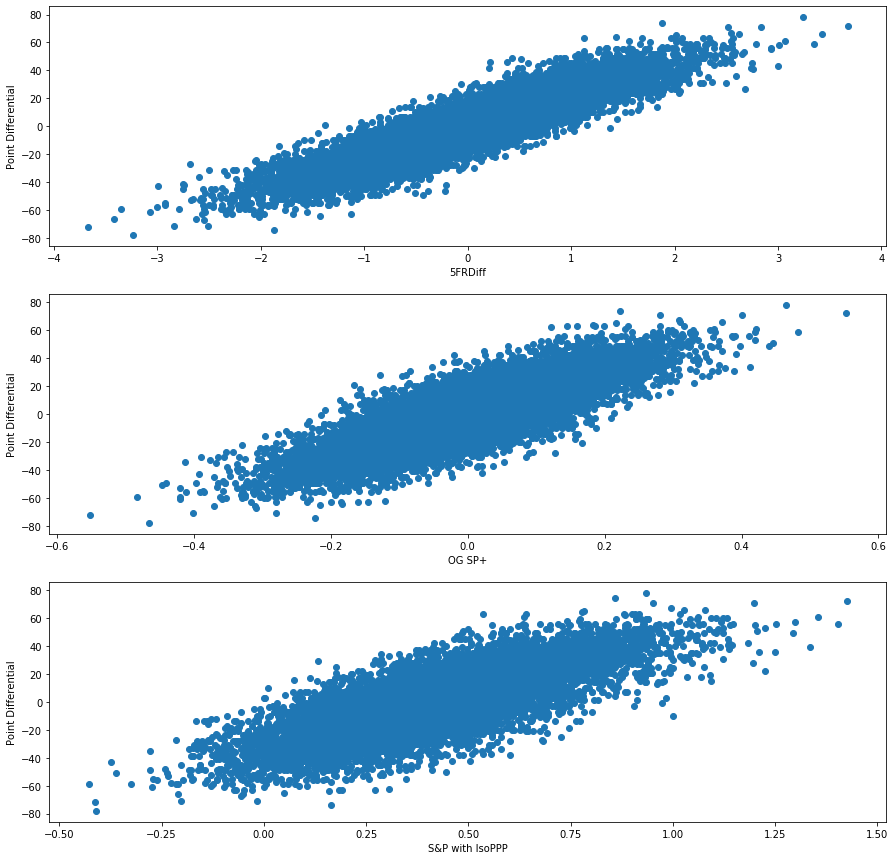

In [18]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [19]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911982,0.759438
S&PIsoPPPDiff,0.911982,1.000000,0.816783
PtsDiff,0.759438,0.816783,1.000000


In [20]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037219,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037219,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474276,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474276,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583586,0.499553


In [21]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [22]:
# outliers

In [23]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037219,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037219,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474276,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474276,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583586,0.499553


In [24]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [25]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.61806x + 0.05090
Mean Pred Score: -0.008207726076009897
Pred Std Dev: 19.227492896804133
Mean Abs Error: 7.604574885293746
Mdn Abs Error: 6.305845611915158
R-squared: 0.8026741623627967



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.760649,0.575878,0.472968,0.787879,0.590531,0.607566,0.983983,0.514701,0.777319,...,0.518438,0.434920,0.237309,0.166041,0.048887,0.107256,0.146214,0.896072,0.896072,0.896072
OffSRDiff,0.760649,1.000000,0.499852,0.277767,0.696819,0.379304,0.430206,0.757322,0.747434,0.717785,...,0.523413,0.384387,0.189226,0.111325,-0.000808,0.048546,0.045989,0.919430,0.919430,0.919430
OffERDiff,0.575878,0.499852,1.000000,0.145209,0.508049,0.277098,0.321266,0.564087,0.374230,0.810135,...,0.186380,0.189904,0.123423,0.056113,0.035788,0.066244,0.020589,0.535828,0.535828,0.535828
FPDiff,0.472968,0.277767,0.145209,1.000000,0.588941,0.070147,0.070562,0.445708,0.045371,0.212395,...,0.248922,0.240338,0.315300,0.240672,0.210528,0.228689,0.141976,0.546055,0.546055,0.546055
OppRateDiff,0.787879,0.696819,0.508049,0.588941,1.000000,0.177742,0.182518,0.785709,0.278496,0.659720,...,0.490754,0.398068,0.243221,0.160431,0.025948,0.085645,0.191298,0.819352,0.819352,0.819352
OppEffDiff,0.590531,0.379304,0.277098,0.070147,0.177742,1.000000,0.755766,0.589346,0.486734,0.417172,...,0.282182,0.238479,0.103662,0.067687,0.024783,0.044863,0.350022,0.472548,0.472548,0.472548
OppPPDDiff,0.607566,0.430206,0.321266,0.070562,0.182518,0.755766,1.000000,0.615983,0.545025,0.471363,...,0.324405,0.277210,0.099839,0.075396,0.023990,0.054303,0.038380,0.548462,0.548462,0.548462
PPDDiff,0.983983,0.757322,0.564087,0.445708,0.785709,0.589346,0.615983,1.000000,0.513312,0.765497,...,0.522923,0.435830,0.234922,0.152936,0.039564,0.108936,0.140056,0.888304,0.888304,0.888304
OppSRDiff,0.514701,0.747434,0.374230,0.045371,0.278496,0.486734,0.545025,0.513312,1.000000,0.536729,...,0.356444,0.239054,0.141224,0.059278,-0.011108,0.011891,-0.068723,0.667599,0.667599,0.667599
YPPDiff,0.777319,0.717785,0.810135,0.212395,0.659720,0.417172,0.471363,0.765497,0.536729,1.000000,...,0.432944,0.382980,0.151775,0.084418,-0.002755,0.036502,0.039885,0.756802,0.756802,0.756802


In [26]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.765525,0.760649,0.724072,0.906116,0.472968,0.473119,0.896072,0.896072,0.896072
ActPts,0.765525,1.000000,0.592157,0.559467,0.705982,0.360226,0.351952,0.693976,0.693976,0.693976
Eff,0.760649,0.592157,1.000000,0.639431,0.803361,0.277767,0.235609,0.919430,0.919430,0.919430
Expl,0.724072,0.559467,0.639431,1.000000,0.686382,0.199638,0.218164,0.690206,0.690206,0.690206
FinDrv,0.906116,0.705982,0.803361,0.686382,1.000000,0.401313,0.415051,0.924425,0.924425,0.924425
FldPos,0.472968,0.360226,0.277767,0.199638,0.401313,1.000000,0.349118,0.546055,0.546055,0.546055
Trnovr,0.473119,0.351952,0.235609,0.218164,0.415051,0.349118,1.000000,0.457116,0.457116,0.457116
5FR,0.896072,0.693976,0.919430,0.690206,0.924425,0.546055,0.457116,1.000000,1.000000,1.000000
5FRDiff,0.896072,0.693976,0.919430,0.690206,0.924425,0.546055,0.457116,1.000000,1.000000,1.000000
PredPtsDiff,0.896072,0.693976,0.919430,0.690206,0.924425,0.546055,0.457116,1.000000,1.000000,1.000000


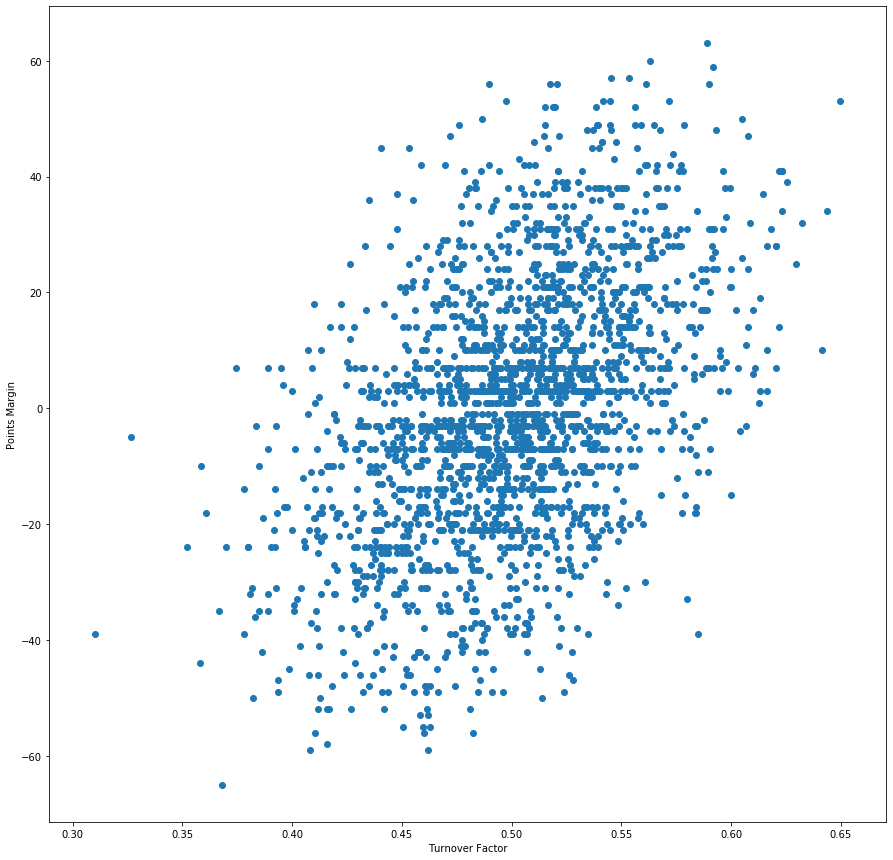

In [27]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

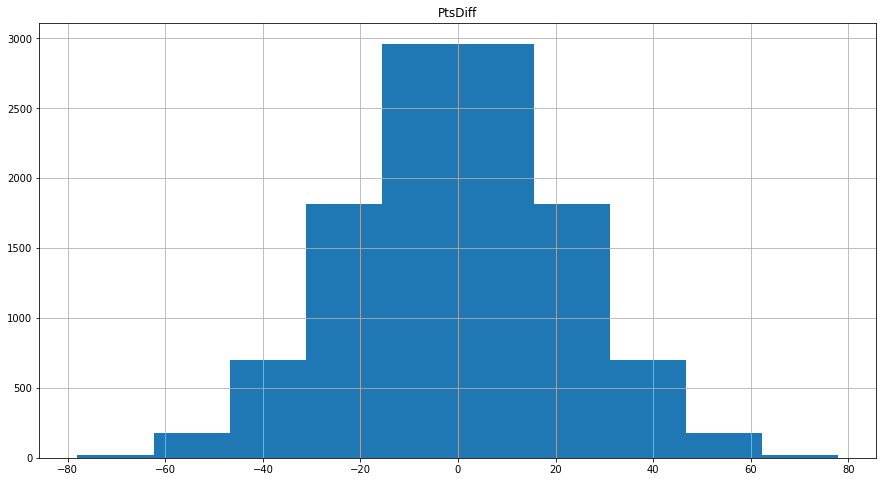

In [28]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

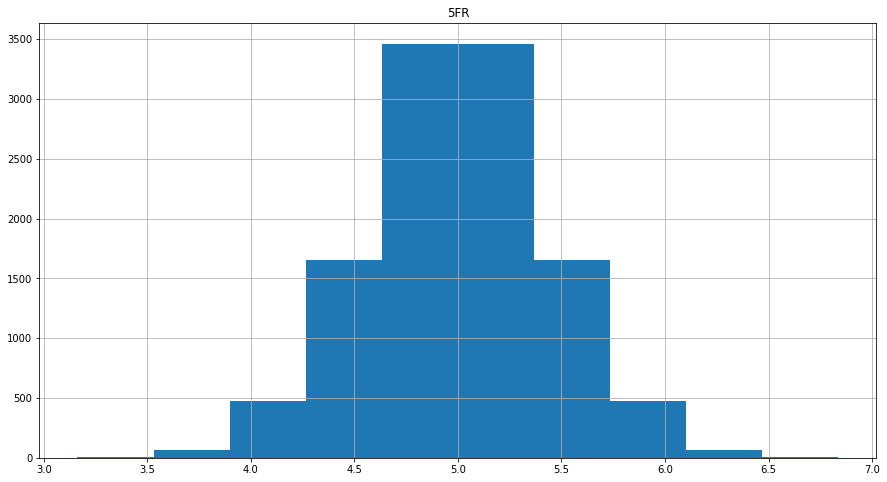

In [29]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

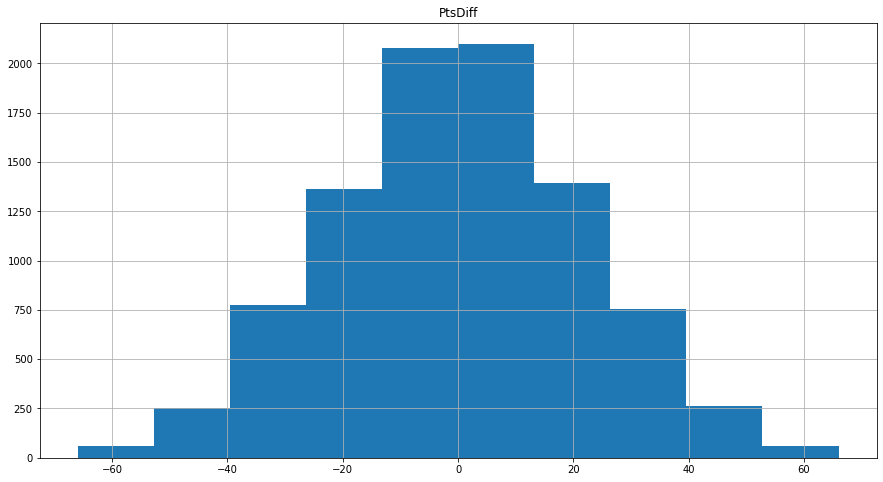

In [30]:
train_data.hist(column='PtsDiff', figsize=(15,8));

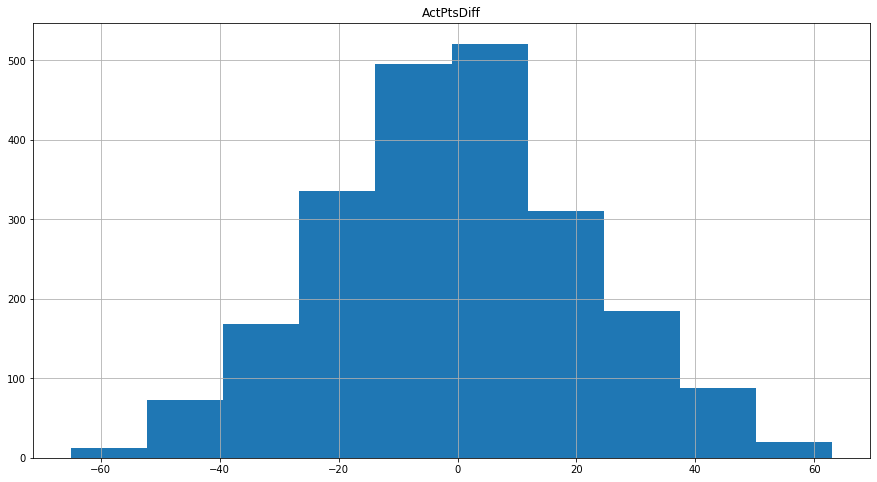

In [31]:
test.hist(column='ActPtsDiff', figsize=(15,8));

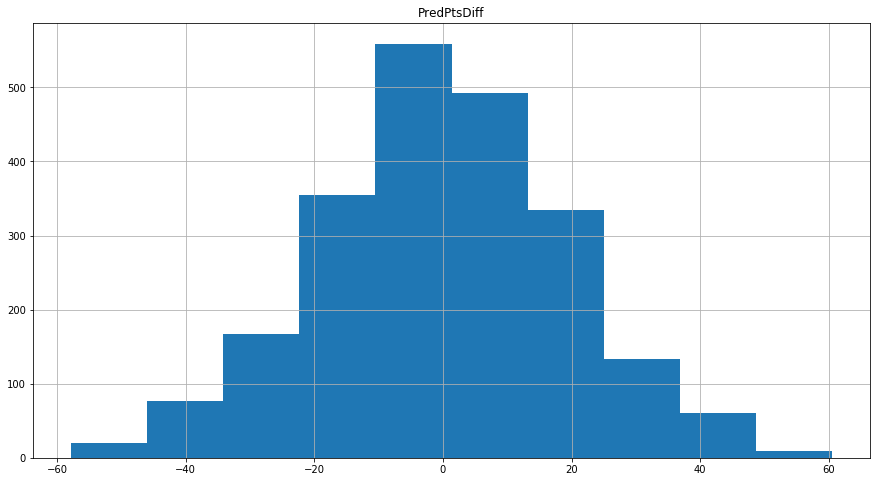

In [32]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [33]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [34]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.1413358531962268)
Z score: -0.1629504243707709
Win Prob for Virginia Tech: 43.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [35]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.23539953583798)
Z score: -0.5839134550728701
Win Prob for Georgia Tech: 27.96%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [36]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.5197687386815927)
Z score: -0.02660570545266518
Win Prob for Georgia Tech: 48.94%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [37]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.567698189166636)
Z score: 0.18597879268165066
Win Prob for Mississippi State: 57.38%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [38]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -4.92343306476472)
Z score: -0.25563527003074266
Win Prob for Texas A&M: 39.91%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [39]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.946248,13,12.0,1.0
2,Clemson,0.939859,13,12.0,1.0
3,Alabama,0.916780,12,11.0,1.0
4,LSU,0.915269,13,12.0,1.0
5,Wisconsin,0.879748,13,11.0,2.0
6,Utah,0.850608,13,11.0,2.0
7,Oklahoma,0.833425,13,11.0,2.0
8,Oregon,0.820053,13,11.0,2.0
9,Appalachian State,0.804935,13,10.0,3.0
10,Georgia,0.796935,13,10.0,3.0


In [40]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.566401,1.433599
21,Clemson,10.652140,2.347860
53,LSU,10.446954,2.553046
128,Wisconsin,9.670378,3.329622
2,Alabama,9.345975,2.654025
115,Utah,9.214231,3.785769
78,Oklahoma,9.121811,3.878189
3,Appalachian State,8.800399,4.199601
82,Oregon,8.792691,4.207309
34,Georgia,8.579162,4.420838


In [41]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
5,Fresno State,2012,5.309021,6
6,Georgia,2012,5.304040,7
7,Notre Dame,2012,5.289858,8
8,Utah State,2012,5.267835,9
9,Kansas State,2012,5.266560,10


In [42]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [43]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.14322132767711854, -20.503906448731662]

In [110]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    
    ['Ohio', 'Nevada', 7.5],
    
    ['Tulane', 'Southern Mississippi', 7],
    
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Auburn,Minnesota,7.5,-0.008072,0.500003,False,Minnesota,Minnesota
0,Alabama,Michigan,7.0,4.409445,0.590860,False,Alabama,Michigan
0,Wisconsin,Oregon,2.5,1.320428,0.527545,False,Wisconsin,Oregon
0,Georgia,Baylor,7.5,-2.813570,0.441999,False,Baylor,Baylor
0,Cincinnati,Boston College,7.0,-5.775563,0.382106,False,Boston College,Boston College
0,Tennessee,Indiana,1.5,-1.390880,0.471336,False,Indiana,Indiana
0,Ohio,Nevada,7.5,6.226286,0.627125,False,Ohio,Nevada
0,Tulane,Southern Mississippi,7.0,-1.876270,0.461301,False,Southern Mississippi,Southern Mississippi
0,Louisiana,Miami (OH),14.0,-0.056543,0.498997,False,Miami (OH),Miami (OH)


In [45]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.3269033496263522)
Z score: 0.017428745260806313
Win Prob for Virginia: 50.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [46]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.533115702690388)
Z score: 0.5482422219757266
Win Prob for North Carolina: 70.82%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [47]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.019411348111365)
Z score: 0.9896047901986234
Win Prob for Pittsburgh: 83.88%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [48]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.607575028920323)
Z score: -0.49925215702146253
Win Prob for Auburn: 30.88%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [49]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.08532197497725)
Z score: 1.7731656375605818
Win Prob for Georgia: 96.19%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5,4.247627,-1.504745


In [50]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

['Georgia Tech', 'Clemson']
['South Florida', 'Georgia Tech']
['The Citadel', 'Georgia Tech']
['Georgia Tech', 'Temple']
['North Carolina', 'Georgia Tech']
['Georgia Tech', 'Duke']
['Georgia Tech', 'Miami']
['Pittsburgh', 'Georgia Tech']
['Georgia Tech', 'Virginia']
['Virginia Tech', 'Georgia Tech']
['NC State', 'Georgia Tech']
['Georgia', 'Georgia Tech']
Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22.0 (exact value: 21.595408868225736)
Z score: 1.1235794864286521
Win Prob for Clemson: 86.94%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 10.0 (exact value: 9.520576605145683)
Z score: 0.4955812170813754
Win Prob for Georgia Tech: 68.99%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -10.0 (exact value: -10.432787699752106)
Z score: -0.5421705278803562
Win Prob for The Citadel: 29.39%
---
Game: Georgia 

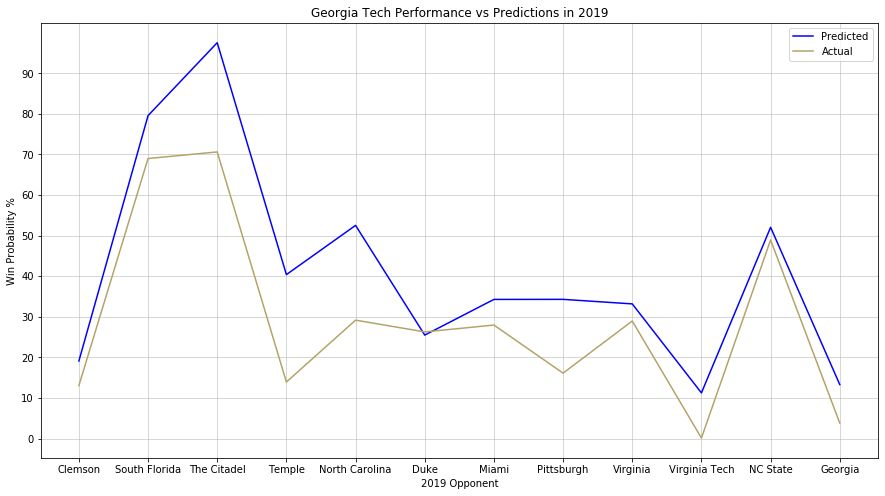

In [51]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

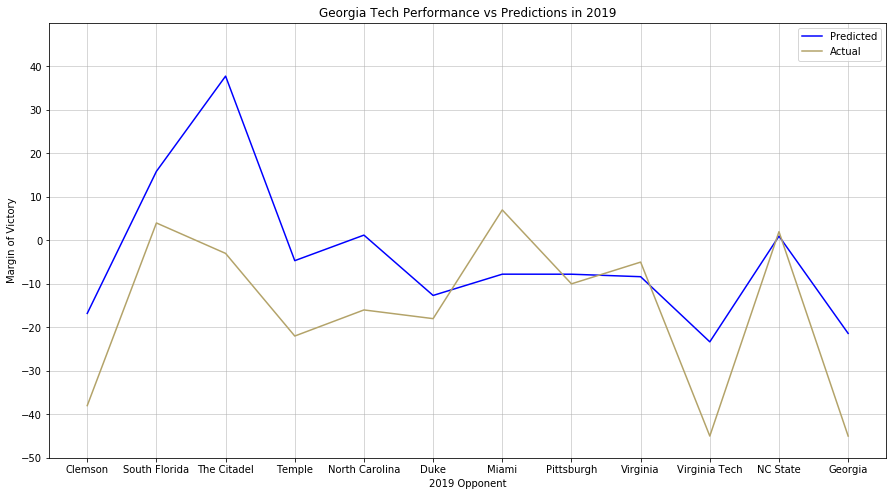

In [52]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

['Alcorn State', 'Georgia Tech']
['Georgia Tech', 'South Florida']
['Georgia Tech', 'Pittsburgh']
['Clemson', 'Georgia Tech']
['Bowling Green', 'Georgia Tech']
['Georgia Tech', 'Louisville']
['Duke', 'Georgia Tech']
['Georgia Tech', 'Virginia Tech']
['Georgia Tech', 'North Carolina']
['Miami', 'Georgia Tech']
['Virginia', 'Georgia Tech']
['Georgia Tech', 'Georgia']
Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.03008004899477)
Z score: 2.082345732226258
Win Prob for Georgia Tech: 98.13%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 8.0 (exact value: 8.292102846293567)
Z score: 0.43168969646319305
Win Prob for South Florida: 66.70%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 7.184817458587064)
Z score: 0.3741010449603989
Win Prob for Pittsburg

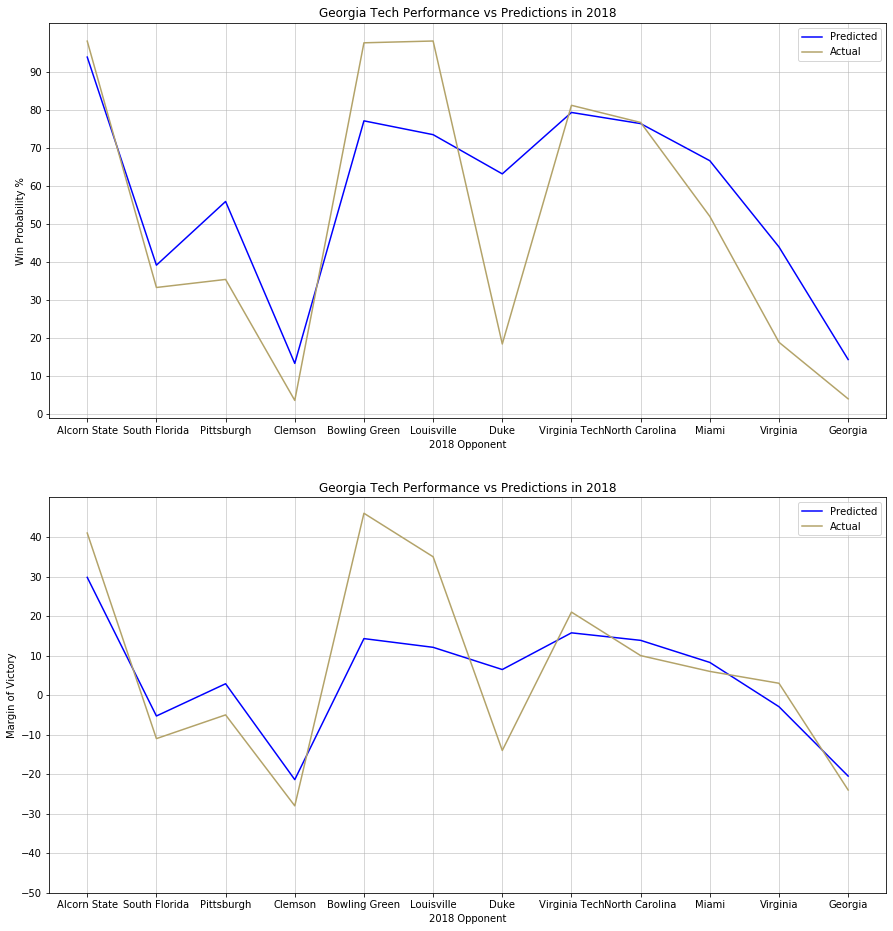

In [53]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

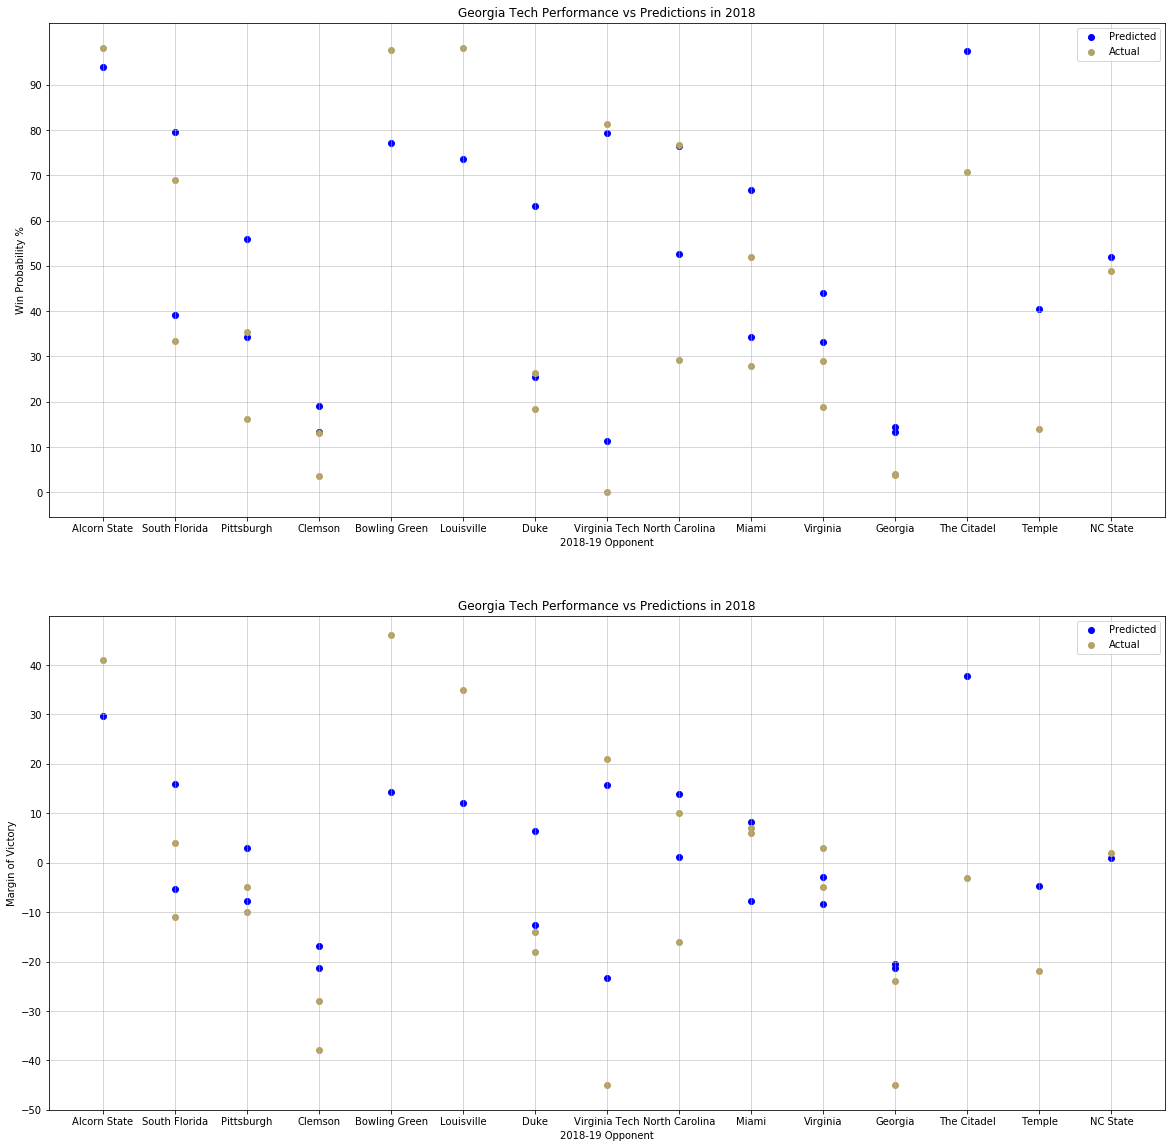

In [54]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [55]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.588419,0.525915,0.451663,0.382888,0.294898,0.300102,0.363730
2013,0.588419,1.000000,0.562651,0.366462,0.245886,0.260369,0.185906,0.279507
2014,0.525915,0.562651,1.000000,0.616098,0.486532,0.332827,0.332063,0.386230
2015,0.451663,0.366462,0.616098,1.000000,0.656853,0.472454,0.379344,0.403584
2016,0.382888,0.245886,0.486532,0.656853,1.000000,0.602837,0.417091,0.594324
2017,0.294898,0.260369,0.332827,0.472454,0.602837,1.000000,0.634993,0.569357
2018,0.300102,0.185906,0.332063,0.379344,0.417091,0.634993,1.000000,0.610011
2019,0.363730,0.279507,0.386230,0.403584,0.594324,0.569357,0.610011,1.000000


In [56]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,36.856355,-6.462113
1,2020,North Carolina,Auburn,Home,29.462994,-10.389302
2,2020,North Carolina,James Madison,Home,97.945842,39.267595
3,2020,North Carolina,Connecticut,Home,75.609548,13.331784
4,2020,North Carolina,Boston College,Away,46.265325,-1.810816
5,2020,North Carolina,Duke,Away,48.813830,-0.579981
6,2020,North Carolina,Miami,Away,37.781473,-5.992287
7,2020,North Carolina,Georgia Tech,Home,60.346755,5.035794
8,2020,North Carolina,NC State,Home,56.468222,3.123013
9,2020,North Carolina,Pittsburgh,Home,48.479934,-0.740999


In [57]:
generate_win_prob(401135282, 2019)
box2 = calculate_box_score(401135282, 2019)
# testDiffs = ["Team",'5FRDiff']
print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135282 locally, checking CFB Data API
Could not find drive data for game_id 401135282 locally, checking CFB Data API
Could not find play by play data for game_id 401135282 locally, checking CFB Data API
Game: Florida @ Virginia
Actual Winner: Florida
MOV: Florida by 8
Proj MOV: Florida by -5.0 (exact value: -5.462998370964813)
Z score: -0.2836974468884325
Win Prob for Florida: 38.83%
---
Could not find basic game data for game_id 401135282 locally, checking CFB Data API
Could not find drive data for game_id 401135282 locally, checking CFB Data API
Could not find play by play data for game_id 401135282 locally, checking CFB Data API
       Team         FP    FPDiff
0   Florida  22.250000 -7.204545
1  Virginia  29.454545  7.204545


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Florida,4.872312,4.998002,4.970375,4.279545,4.99888,4.878109,-0.243783
1,Virginia,5.127688,5.001998,5.029625,5.720455,5.00112,5.121891,0.243783


In [58]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.4128071065302552, -4.244599865625784]

In [59]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [95]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam, "AwayScore": lines.awayScore,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [103]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,536,156,0,0.774566
1,ATS,2013,382,302,8,0.552023
0,ML,2014,502,146,0,0.774691
1,ATS,2014,399,233,16,0.615741
0,ML,2015,533,142,0,0.789630
1,ATS,2015,396,261,18,0.586667
0,ML,2016,523,153,0,0.773669
1,ATS,2016,400,258,18,0.591716
0,ML,2017,562,158,0,0.780556
1,ATS,2017,420,280,20,0.583333


In [109]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7743314110629581
Avg ATS Win %: 0.5807432660975046


In [102]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

[Simulation] Retrieving box score entries for 2019 season...
[Simulation] Retrieved 732 box scores for 2019 season, pulling betting lines...
[Simulation] Retrieved 732 games with betting lines for 2019 season.
[Simulation] Creating projections for 732 games and analyzing spreads...
[Simulation] Finished creating spread analysis.


,pick_category,season,W,L,D,WinPct
0,ML,2019,564,168,0,0.770492
1,ATS,2019,414,307,11,0.565574
